![](./assets/header-logo.png)

## *Semantic Point Cloud Segmentation*

**Automated and Connected Driving Challenges - Research Project (Summer Term 2022)**

**Research Topic *2: Domain Adaptation of Semantic Point Cloud Segmentation***



| Marco Buller | marco.buller@rwth-aachen.de / marco.buller@web.de | 377669 |
| --- | --- | --- |



In [ ]:
# !-- Before any code cell can be executed, make sure that you have Jupyter installed in your Python environment. --!
#     !pip install jupyter

# === INSTALLATION OF PYTHON DEPENDENCIES ==========================

from ast import YieldFrom
import sys

# install packages via pip
!{sys.executable} -m pip install \
    jupyter \
    tensorflow==2.10.0 \
    matplotlib==3.5.2 \
    numpy \
    opencv-python \
    beeprint \
    tqdm \
    ipykernel \
    virtualenv \
    pyntcloud \
    plotly \
    seaborn \
    easydict \
    nuscenes-devkit


If the problems with the base environment occur create a new environment by running `conda create -n <env_name> python=3.7`  
When using Visual Studio Code, you will probably need to reload the window and switch again the kernel (top-right corner) to the new environment.  
  
If you still have problems executing the code, especially with tensorflow commands, you can also create the environment with the given `environment.yaml` file as follows: `conda env create -f environment.yaml -n <env_name>`

In [4]:
import os
import cv2
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow as tf
from easydict import EasyDict
import scipy
import random
import glob
from packaging import version
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import plotly.graph_objects as go
from tqdm.notebook import tqdm
from IPython.display import display, Image

from pcl_segmentation_utils import CAM, FIRE, FIREUP

tf.random.set_seed(42)
random.seed(123)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

if not (version.parse("2.5.0") <= version.parse(tf.__version__) <= version.parse("2.7.0")): print("To ensure error-free execution of the notebook, please install a Tensorflow version between and included 2.5.0 and 2.7.0")
if (sys.version_info <= (3,7)): print("For error-free execution of the notebook, please install a Python version higher or equal to 3.7")



#### __Abstract__

__Systems developed for autonomous vehicles must be transferable to any open-world setting. This means that these systems can be subjected to constant domain shifts by being transferred to other settings. In order to meet the safety requirements of self-driving vehicles, there should be no loss of performance. The performance of semantic segmentations of LiDAR point clouds in particular is limited by the availability of labelled standardised data sets and has thus become the focus of domain adaptation. In order to develop practical systems that can handle domain shifts, an indepth investigation of techniques and methods for improving domain adaptation performance is necessary. Comprehensive experiments can be used to derive generally applicable implementation recommendations that improve the domain shift capabilities of prediction models for LiDAR point cloud segmentation. To stimulate research into the technical implementation of domain adaptation in this area, this report investigates low-level implementation rules compared to existing reference benchmark models.__

### **Introduction**

Scene understanding is an essential requirement for autonomous vehicles. Necessary for this is semantic segmentation to give meaning to a scene by assigning class labels. Nowadays, semantic segmentation is the basis of three-dimensional scene understanding and achieves good performance in the areas of mapping geographical information, navigation and positioning, computer vision, and pattern recognition [[1 p.1]](https://ieeexplore.ieee.org/document/8930503). In detail, a semantic label is predicted on the LiDAR point cloud data during segmentation (see [Fig.1](./assets/semantic-ptcl.gif)). Especially for safety-critical systems such as autonomous vehicles, high accuracy of class label prediction is essential [[2 p.1]](https://arxiv.org/abs/2003.03653). In recent years, the results of point cloud segmentation with convolutional neural networks (CNN) have improved significantly [[3 p.211]](https://www.sciencedirect.com/science/article/abs/pii/S0924271621001131?via%3Dihub). However, their performance is still limited by the availability of labelled training data, as dataset generation and labelling is very expensive [[4 p.1]](http://arxiv.org/pdf/2007.08488v2). In addition, due to the lack of standards or norms published datasets vary significantly in their structure, class number, sensor type, etc. As a result, it is common that a prediction model when transferred to a slightly different use case, for example undergoing a domain shift, shows a significant reduction in performance [[5 p.350]](https://ieeexplore.ieee.org/document/9669228/).  
  
<img src="./assets/semantic-ptcl.gif" width="600">  

[Fig.1: Example of point cloud segmentation for vehicles in practice](https://pythonawesome.com/semantic-and-instance-segmentation-of-lidar-point-clouds-for-autonomous-driving/)
  
For this reason, transfer learning and in particular domain adaptation have recently become more important [[3 p.211]](https://www.sciencedirect.com/science/article/abs/pii/S0924271621001131?via%3Dihub). Through good domain adaptation capability of a model, it can be applied to new domains without performance losses. Domain adaptation is thus a cost-effective and fast solution for dealing with domain shifts [[5 p.350]](https://ieeexplore.ieee.org/document/9669228/). Comparable literature in this area deals mainly with the classification of domains to scopes and thus represents more of a structuring of existing methods [[5]](https://ieeexplore.ieee.org/document/9669228/)[[18]](https://ieeexplore.ieee.org/document/9578083). In this work, domain adaptation is to be considered more deeply in order to derive implementation recommendations for certain methods and techniques on the basis of structured experiments. In the process, results obtained are classified using benchmark models and examined from different perspectives. A summary model will also be analysed and put into perspective.  
  
The research work is organised as follows: In the chapter __Related Work__, basic terminology is introduced and explained on the basis of related literature. Based on this, the chapter __Methodology__ derives and defines methodologies in order to be able to investigate the selected aspects. __Experiments__ describes the execution of the previously defined methods in order to be able to categorise and analyse the results obtained in the chapter __Evaluation__. Finally, the core research statements are summarised in the __Conclusion__ and an outlook on further research approaches is given.

### **Related Work**

First, the terminology that is important for this research will be introduced and classified in more detail. In order to achieve the most comprehensive view possible, reference is made to related research work at given points. In this section the related works regarding point cloud segmentation, LiDAR point cloud datasets and domain adaptation is discussed.
  
#### 3D LiDAR Point Cloud Segmentation
  
Segmentation refers to the dividing of an initial domain into coherent groups or parts without taking semantic information into account and has its origins in image processing. For point cloud data, however, semantic segmentation has proven to be a fundamental task [[6 p.38f]](https://doi.org/10.1109/MGRS.2019.2937630). This describes the recognition of objects in the source domain through point-wise labelling [[7 p.4377]](https://ieeexplore.ieee.org/document/8793495).   
To accomplish this task two different approaches are basically considered in the literature: Machine Learning methods and Deep Learning methods. Machine learning methods are fundamentally based on the pioneering work of _Lalonde et al._ in [[8]](https://ieeexplore.ieee.org/document/1443257?reason=concurrency) and typically involve various steps such as ground removal, clustering and classification [[9]](https://ieeexplore.ieee.org/document/5164280)[[10]](https://ieeexplore.ieee.org/document/5979818)[[11]](https://ieeexplore.ieee.org/document/7989591). In the last decade the focus has shifted to Deep Learning based approaches with the introduction of VoxNet [[12]](https://ieeexplore.ieee.org/document/7353481) [[7 p.4377]](https://ieeexplore.ieee.org/document/8793495).  
The Deep Learning methods can be divided into three main groups: 1.) _Voxel-based_ [[13]](https://ieeexplore.ieee.org/document/8953494)[[14]](https://ieeexplore.ieee.org/document/8579059)[[15]](https://ieeexplore.ieee.org/document/9156460) and 2.) _Projection-based_ [[2]](https://arxiv.org/abs/2003.03653)[[16]](https://ieeexplore.ieee.org/document/9157034)[[17]](https://ieeexplore.ieee.org/document/8967762) approaches apply a structure on an unstructured point cloud before convolution. In voxel-based methods, 3D-CNN architectures can be easily applied, but these approaches have a very high computation and memory usage. Projection-based methods project the 3D point cloud into 2D images. This may result in the loss of critical geometric information, but it achieves a much faster runtime compared to competing approaches [[18 p.4979]](https://ieeexplore.ieee.org/document/9578083)[[19 p.1]](https://doi.org/10.3390/electronics11010011). 3) _Point-based_ architectures [[20]](https://ieeexplore.ieee.org/document/8099499)[[21]](https://arxiv.org/abs/1706.02413)[[22]](https://arxiv.org/abs/1801.07791), on the other hand, process the point cloud directly based on simple multi layer perceptrons (MLP). With this method good results can be achieved with efficient computation. However, since the semantic of each point is taken into account these advantages only arise for small-scale point clouds [[18 p.4979]](https://ieeexplore.ieee.org/document/9578083). A main field of research in this area is the improvement of performance on large-scale point clouds as investigated in [[23]](https://link.springer.com/chapter/10.1007/978-3-030-11015-4_29) or [[24]](https://ieeexplore.ieee.org/document/8578577/). 
For a more comprehensive overview please refer to [[25]](https://arxiv.org/abs/1912.12033) and [[26]](https://www.mdpi.com/2072-4292/12/11/1729).  
  
#### Datasets
  
Basically, the 3D LiDAR point cloud datasets can be classified into four levels based on the scope and size. Object-level [[27]](https://ieeexplore.ieee.org/document/7298801), indoor scene-level [[28]](https://link.springer.com/chapter/10.1007/978-3-642-33715-4_54), outdoor roadway-level [[29]](https://ieeexplore.ieee.org/document/9010727) and urban aerial-level [[30]](https://www.researchgate.net/publication/334612380_DublinCity_Annotated_LiDAR_Point_Cloud_and_its_Applications). Overall, only a few 3D LiDAR point cloud datasets are made public available as the generation and labelling of these datasets is very complex and therefore cost-intensive [[18 p.4977]](https://ieeexplore.ieee.org/document/9578083). Since there are still no global standards the data sets differ greatly from one another so that only certain data sets support e.g. semantic segmentation through several class labels [[31 p.2]](http://arxiv.org/pdf/2112.12610v1).  
  
#### Domain Adaptation
  
In general, Domain Adaptation (DA) describes the process of transferring a task originating from one domain to another target domain that is similar and related to the source domain. In the Deep Learning context DA is a special type of transfer learning. Transfer learning and thus DA can be divided into three categories: 1.) _unsupervised transfer learning_, where no annotated data exists. 2.) _transductive transfer learning_, where only the source domain contains annotations. 3.) _inductive transfer learning_, which also has annotations in the target domain. [[5 p.351]](https://ieeexplore.ieee.org/document/9669228/)  
Since 3D point clouds are typically unstructured and disordered, unsupervised DA is particularly difficult. So Adversarial Learning-Based Unsupervised DA and Multi-Modality Learning have evolved from this method which are studied in more detail in [[3]](https://www.sciencedirect.com/science/article/abs/pii/S0924271621001131?via%3Dihub). 
In this paper, transductive transfer learning is considered. DA is therefore summarised by the task of transferring a model from one labelled source domain to another unlabelled target domain.  
Various combinations are possible in the composition of source and target domains, which differ in the type and properties of the domain. The most common and general application is the _dataset-dataset_ DA as it includes several subtasks such as _sensor-sensor_, _weather-weather_, _day-night_ or _county-country_ DA. With the selection of datasets in general and the selection of the considered samples in the respective datasets, these subtasks can be controlled and adjusted in a _dataset-dataset_ DA. Due to the complex generation of real datasets, _simulation-real_ DA has also developed in the past where simulation frameworks such as _CARLA_ [[32]](https://www.researchgate.net/publication/321025516_CARLA_An_Open_Urban_Driving_Simulator) or _GTA-V_ LiDAR [[33]](https://par.nsf.gov/servlets/purl/10109208) are used as the initial dataset and the application to the real world is investigated. [[5 p.352]](https://ieeexplore.ieee.org/document/9669228/)[[3 p.215]](https://www.sciencedirect.com/science/article/abs/pii/S0924271621001131?via%3Dihub)  

### **Methodology**

As described in the previous chapter, there are several approaches to consider and investigate the Domain Adaptation (DA) of Semantic Point Cloud Segmentation. In this paper, DA techniques are considered from a practical point of view with direct reference to the segmentation model and implementation recommendations are derived from this. The focus is on the three main drivers for improving Generalization and hence DA. First, the selection of data sets in general is discussed followed by an in-depth look at data augmentation and finally the structure and the tuning of the model itsef is examined.  
  
#### Dataset
  
The basic idea of dataset selection in the context of DA is that the segmentation model is trained on a source dataset and the performance of the fitted model is examined on an unknown target dataset that is different from the initial dataset. This DA methodology forms the basis of the investigations in this paper.  
Another component of the investigations is the influence and structure of the selected source dataset. Certain training datasets can improve model transferability to other target datasets more than others. This issue is investigated using three selected datasets to establish correlations between dataset structure and DA. The selected datasets are _SemanticKITTI_ [[29]](https://ieeexplore.ieee.org/document/9010727) and _nuScenes_ [[34]](https://ieeexplore.ieee.org/document/9156412) dataset as two public datasets that are most widely used in research. In addition, these datasets have different domain shifts in terms of country, day/night and number of scenes in a direct comparison. These datasets will serve as the source datasets. As a third dataset, an ika institute-internal dataset is used as it is very suitable as a representative of a domain shift by a completely new scenario. This dataset, in the following referred to as the "_ika-dataset_", will thus be used as a validation data set. An overview of the structure and properties of the data sets is given in the following table:  

| Datasets | samples | scenes | LiDAR sensor | classes | day/night | country |
| --- | --- | --- | --- | --- | --- | --- |
| ika-dataset | 250 | 1 | 1 (spinning) | 11 | day | DE |
| SemanticKitti | 23201 | 22 | 1 (spinning) | 25 | day | USA+Singapore |
| NuScenes | 34149 | 1000 | 1 (spinning) | 23 | day+night | DE |

First, the datasets need to be downloaded. The "_ika-dataset_* is given with this report. The *_SemanticKITTI_* and *_nuScenes_* dataset kan be downloaded from the corresponding websites:  
**SemanticKITTI:** http://www.semantic-kitti.org/dataset.html#download  
**nuScenes:** https://www.nuscenes.org/nuscenes#download  
  
__NOTE:__ The datasets as used here are preprocessed so that they have a uniform structure. The details of this preprocessing are not discussed further, as this is independent of the research results and the basic structure of the downloaded commercial datasets may change over time. Basically, the datasets are aligned to the structure of the *_ika-dataset_*. This structure can be taken from the *_ika-dataset_*, which is deposited in this repo.

In [44]:
### Store paths to the selected datasets
# relative paths to the datasets
train_path_ika = "data/pcl_segmentation/ika/train"
train_path_kitti = "data/pcl_segmentation/converted_dataset_kitti/train"
train_path_nusc = "data/pcl_segmentation/converted_dataset_nuscenes/train"

val_path_ika = "data/pcl_segmentation/ika/val"
val_path_kitti = "data/pcl_segmentation/converted_dataset_kitti/val"
val_path_nusc = "data/pcl_segmentation/converted_dataset_nuscenes/val"


# store all file paths in dict
data_paths = EasyDict(
                        {'TRAIN':{'IKA':sorted(glob.glob(os.path.join(train_path_ika, "*.npy"))),
                                  'KITTI':sorted(glob.glob(os.path.join(train_path_kitti, "*.npy"))),
                                  'NUSC':sorted(glob.glob(os.path.join(train_path_nusc, "*.npy")))
                                  },
                         'VAL':{'IKA':sorted(glob.glob(os.path.join(val_path_ika, "*.npy"))),
                                'KITTI':sorted(glob.glob(os.path.join(val_path_kitti, "*.npy"))),
                                'NUSC':sorted(glob.glob(os.path.join(val_path_nusc, "*.npy")))
                                }
                        }
)

# print number of samples
print("Number of training samples form ika dataset: ", len(data_paths.TRAIN.IKA))
print("Number of training samples from SemanticKitti dataset: ", len(data_paths.TRAIN.KITTI))
print("Number of training samples from NuScenes dataset: ", len(data_paths.TRAIN.NUSC), "\n")
print("Number of validation samples from ika dataset: ", len(data_paths.VAL.IKA))
print("Number of validation samples from SemanticKITTI dataset: ", len(data_paths.VAL.KITTI))
print("Number of validation samples from NuScenes dataset: ", len(data_paths.VAL.NUSC))


Number of training samples form ika dataset:  200
Number of training samples from SemanticKitti dataset:  20880
Number of training samples from NuScenes dataset:  25611 

Number of validation samples from ika dataset:  50
Number of validation samples from SemanticKITTI dataset:  2321
Number of validation samples from NuScenes dataset:  8538


The datasets available via the download link above do not correspond exactly to the original datasets. This is due to the fact that the structure of the datasets must first be aligned to enable a proper comparison between them as there are no standards or norms for the dataset format. 
For this purpose, the point cloud scans are opened and the points of these scans are projected into a 2D plane and saved as `*.npy` files. In addition, the number of classes and class labels are summarised to the 11 classes of the ika dataset. The resulting `*.npy` files then each contain a tensor of the size _2D-Height x 2D-Width x channels_. The six channels are as follows:  
  
| index | channel |
|---|---|
| 0 | x-coordinate in [m] |
| 1 | y-coordinate in [m] |
| 2 | z-coordinate in [m] |
| 3 | intensity |
| 4 | depth in [m] |
| 5 | label ID |


The converted datasets are then preprocessed for semantic segmentation in the next step. Various auxiliary functions are necessary for this. These will not be discussed further here as the focus of this work is on the DA techniques. To enable visualisation of the results, different colours are assigned to the 11 classes. 

#### General Preprocessing Functions

In [45]:
def calc_mean(data_paths):
    """
    Calculates the overall mean value of the x,y,z,depth,intensity values of a dataset for normalization
    
    Arguments:
    data_paths -- List - File paths to the sample .npy files of the desired dataset
    
    Returns:
    norm_mean -- Array - With the overall mean values of the x,y,z,depth,intensity values
    """
    
    norm_mean = []

    for j in range(5):
        mean_arr = np.empty(len(data_paths))
        index = 0
        for i in data_paths:
            sample = np.load(i)
            mask = sample[:,:,4] > 0
            mean = np.mean(sample[:,:,j][mask])
            mean_arr[index] = mean
            index+=1
        norm_mean.append(np.mean(mean_arr))

    return norm_mean

In [46]:
def calc_std(data_paths):
    """
    Calculates the overall standard deviation value of the x,y,z,depth,intensity values of a dataset for normalization
    
    Arguments:
    data_paths -- List - File paths to the sample .npy files of the desired dataset
    
    Returns:
    norm_std -- Array - With the overall std values of the x,y,z,depth,intensity values
    """

    norm_std = []

    for j in range(5):
        var_arr = np.empty(len(data_paths))
        index = 0
        for i in data_paths:
            sample = np.load(i)
            mask = sample[:,:,4] > 0
            var = np.var(sample[:,:,j][mask])
            var_arr[index] = var
            index+=1
        norm_std.append(np.sqrt(np.mean(var_arr)))

    return norm_std

In [47]:
### Define a configuration dictionary
cfg = EasyDict()

# Class name definitions
cfg.CLASSES = ['Road',
              'Sidewalk',
              'Building',
              'Pole',
              'Vegetation',
              'Person',
              'TwoWheeler',
              'Car',
              'Truck',
              'Bus',
              'None']

cfg.NUM_CLASS = len(cfg.CLASSES)

# Color class association
# e.g. Index 0 corresponds to color [128, 64, 128] and class 'Road'
cfg.CLS_COLOR_MAP = np.array([[128,  64,  128],  # Road
                              [244,  35,  232],  # Sidewalk
                              [70,   70,   70],  # Building
                              [153, 153,  153],  # Pole
                              [107, 142,   35],  # Vegetation
                              [220,  20,   60],  # Person
                              [255,   0,    0],  # Two Wheeler
                              [0,     0,  142],  # Car
                              [0,     0,   70],  # Truck
                              [0,    60,  100],  # Bus
                              [0,     0,    0]   # None
                              ]) / 255.0


# Input Shape
# Example value for ika dataset
cfg.AZIMUTH_LEVEL = 240
cfg.ZENITH_LEVEL = 32
cfg.NUM_FEATURES = 6
cfg.BATCH_SIZE = 4

# Data normalization
# x, y, z, intensity, distance
cfg.INPUT_MEAN = np.array([[[24.810, 0.819, 0.000, 16.303, 25.436]]])
cfg.INPUT_STD =  np.array([[[30.335, 7.807, 2.058, 25.208, 30.897]]])
# These are just some default values and will be changed according to the selected dataset later on.


In [49]:
def setConfig(data_paths):
    """
    Sets the dataset-depended configuration parameters
    
    Arguments:
    data_paths -- Array of paths to the point cloud data
    """

    cfg.AZIMUTH_LEVEL = np.shape(np.load(data_paths[0]))[1]
    cfg.ZENITH_LEVEL = np.shape(np.load(data_paths[0]))[0]
    cfg.NUM_FEATURES = np.shape(np.load(data_paths[0]))[2]
    cfg.INPUT_MEAN = np.array([[calc_mean(data_paths)]])
    cfg.INPUT_STD = np.array([[calc_std(data_paths)]])


The size of the data records must be adapted to the batch size. Individual samples are deleted for this purpose.

In [50]:
### Check whether the dataset size matches the batch size
### Delete minimum amount of samples if necessary

# ika-dataset
data_paths.TRAIN.IKA = np.delete(data_paths.TRAIN.IKA, np.arange(len(data_paths.TRAIN.IKA)%cfg.BATCH_SIZE))
print("New number of training samples from ika dataset: ", len(data_paths.TRAIN.IKA))

# SemanticKITTI
data_paths.TRAIN.KITTI = np.delete(data_paths.TRAIN.KITTI, np.arange(len(data_paths.TRAIN.KITTI)%cfg.BATCH_SIZE))
print("New number of training samples from SemanticKITTI dataset: ", len(data_paths.TRAIN.KITTI))

# NuScenes
data_paths.TRAIN.NUSC = np.delete(data_paths.TRAIN.NUSC, np.arange(len(data_paths.TRAIN.NUSC)%cfg.BATCH_SIZE))
print("New number of training samples from NuScenes dataset: ", len(data_paths.TRAIN.NUSC))


New number of training samples from ika dataset:  200
New number of training samples from SemanticKITTI dataset:  20880
New number of training samples from NuScenes dataset:  25608


In the next step we need some functions to create the final datasets which can be used as the input for a convolutional neural network

In [51]:
def segmentation_map_to_rgb_encoding(segmentation_map, class_color_map):
    """
    Converts a segmentation class map into a RGB encoding
    
    Arguments:
    segmentation_map -- Numpy ndarray of shape [height, width] or [height, width, 1] containing class IDs of the defined classes
    class_color_map -- Numpy ndarray of shape [NUM_CLASSES, 3] which contains the RGB values for each class.
    
    Returns:
    rgb_encoding -- Numpy ndarray of shape [height, width, 3] which contains the RGB encoding of the segmentation map
    """
    
    # Store the original shape of the segmentation map
    shape = segmentation_map.shape  
    
    # Flatten segmentation map 
    segmentation_map = segmentation_map.flatten()   
    
    # Convert the segmentation map into np.int32
    segmentation_map = segmentation_map.astype(np.int32)  

    # Extract RGB values
    rgb_encoding = class_color_map[segmentation_map]  
    
    # Reshape to original width and height
    rgb_encoding = rgb_encoding.reshape([shape[0], shape[1], 3])  
    
    return rgb_encoding

In [52]:
def fix_shape(lidar, mask, label, weight, batch_size):
    """
    Sets the correct shape information for the input tensors and the label tensor.
    
    Arguments:
    lidar -- tf.Tensor containing the lidar input tensor. tf.shape information are not assigned
    mask -- tf.Tensor with the lidar mask tensor. tf.shape information are not assigned
    label -- tf.Tensor with the label tensor.  tf.shape information are not assigned
    weight -- tf.Tensor with the weight tensor. tf.shape infomation are not assigned
    
    Returns:
    (lidar, mask) -- Tuple of two tf.Tensors:
                     - lidar tf.Tensor with shape [batch_size, height, width, 6]
                     - mask tf.Tensor with shape [batch_size, height, width]
    label -- tf.Tensor with shape [batch size, height, width]
    weight -- tfTensor with shape [batch size]
    """
    
    lidar.set_shape([batch_size, cfg.ZENITH_LEVEL, cfg.AZIMUTH_LEVEL, 6])  
    mask.set_shape([batch_size,  cfg.ZENITH_LEVEL, cfg.AZIMUTH_LEVEL])  
    label.set_shape([batch_size, cfg.ZENITH_LEVEL, cfg.AZIMUTH_LEVEL])  
    weight.set_shape(batch_size)
    
    return (lidar, mask), label, weight

Under certain conditions, isolated data from the target dataset may already be available when training the model. This data can be used to improve the DA of the model on this specific target dataset. Another thinkable use case is that during the application to a target dataset the trained model is adaptively extended with data samples of the target dataset. These cases are implemented by the possibility of a dataset composition. With the help of this function a dataset can be composed of two datasets in different proportions and a new weight can be assigned to a part of the data.

In [53]:
def dataConcatenate(source_paths, add_paths, add_prop, weight_factor=1.0):
    """
    Helper function to proportional concatenate and shuffle two datasets and set the weights of the added samples
    
    Arguments:
    source_paths -- List of paths to the .npy point cloud data of the source dataset
    add_paths -- List of paths to the .npy point cloud data of the dataset which should be added to the source set
    add_prop -- [0.0, 1.0] - Proportion of the added dataset samples
    weight -- Sample weights of the added samples. The weights of the source samples stay at 1.0
    
    Returns:
    data_paths_con -- List of paths to the .npy point cloud data of the concatenated and shuffled final dataset
    sample_weights_con -- Array of the sample weights for each sample of the concatenated dataset
    """
    # Select proportional parts of the datasets
    data_paths_part1 = np.random.choice(add_paths, size=int(cfg.MAX_TRAIN_SAMPLES * add_prop))
    data_paths_part2 = np.random.choice(source_paths, size=(cfg.MAX_TRAIN_SAMPLES - len(data_paths_part1)))

    # Set the sample weights
    sample_weights1 = np.full(shape=len(data_paths_part1), fill_value=weight_factor)
    sample_weights2 = np.ones((len(data_paths_part2),))

    # Concatenate the Nuscenes data paths part and the whole SemanticKITTI data paths and sample weights
    data_paths_con = np.concatenate([data_paths_part2, data_paths_part1])
    print("Size of concatenated dataset:", len(data_paths_con))
    sample_weights_con = np.concatenate([sample_weights2, sample_weights1])
    print("Size of concatenated sample weight array:", len(sample_weights_con))

    # The data paths and weigths do not need to be shuffled because in create_dataset() shuffling is applied

    return data_paths_con, sample_weights_con


#### Augmentation
  
Data augmentation is used primarily for two use cases. The first is the enlargement of the training dataset with augmented samples. The second, of particular interest for this application, is the generalisation of a dataset. The extent to which different augmentation methods, with which individual samples are changed, can improve the DA is to be investigated. For this purpose, four typical methods for pointclouds will be implemented:  
  
<img src="./assets/augmentation.gif" width="800"> 

[Fig.2: Illustration of considered augmentation methods](https://blog.waymo.com/2020/04/using-automated-data-augmentation-to.html)
  
Functions for the augmentation methods are defined below. The limit values of the function parameters are chosen reasonable. For example, too much rotation is illogical in practice so it is limited to an angle of $\pm 5°$ . When scaling, a scaling factor of more than 1.0 leads to the infeasibility of the neural network training so that only a zoom out can be viewed.

In [54]:
def random_y_flip(sample, prob=0.5):
    """
    Randomply flips a Numpy ndArray along the second axis (y-axis) with probability prob
    
    Arguments:
    sample -- Numpy ndArray of shape [height, width, channels]
    prob -- Float which describes the probability that the flip is applied on the sample.
    
    Returns:
    sample -- Numpy ndArray of shape [height, width, channels] probably flipped on the 2nd axis
    """
    
    if np.random.rand() <= prob: 
        sample = np.fliplr(sample)  
    
    return sample

In [55]:
def random_shift(sample, shift=75, prob=0.5):
    """
    Randomly shifts a sample on the y-axis
    
    Arguments:
    sample -- Numpy ndArray of shape [height, width, channels]
    shift -- Integer which defines the maximal amount of the random horizontal shift
    
    Returns :
    sample -- Numpy ndArray of shape [height, width, channels]
    """
    
    # If the probability constraint is no met, the unedited sample is returned
    if np.random.rand() >= prob:
        return sample

    # Generate a random integer between in [-shift, shift]
    random_y_shift = np.random.randint(low=-shift, high=shift)  
    
    # Perform the shift on the sample
    sample = scipy.ndimage.shift(input=sample,
                                 shift=[0, random_y_shift, 0],
                                 order=0,
                                 mode='wrap')    
    
    return sample

In [56]:
def random_rotate(sample, angle=5, prob=0.5):
    """
    Randomly rotates a sample on the x-y-plane
    
    Arguments:
    sample -- Numpy ndArray of shape [height, width, channels]
    angle -- Integer which defines the maximal amount of the random rotational angle
    
    Returns :
    sample -- Numpy ndArray of shape [height, width, channels]
    """
    
    # If the probability constraint is no met, the unedited sample is returned
    if np.random.rand() >= prob:
        return sample

    # Generate a random integer between in [-shift, shift]
    random_angle = np.random.randint(low=-angle, high=angle)  
    
    # Perform the shift on the sample
    sample = scipy.ndimage.rotate(input=sample,
                                  angle=random_angle,
                                  reshape=False,
                                  order=0,
                                  mode='wrap')    
    
    return sample

In [57]:
def random_scale(sample, zoom_bounds=(0.8, 1.0), prob=0.5):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    
    Arguments:
    sample -- Numpy ndArray of shape [height, width, channels]
    zoom_bounds -- tuple of float with range of zoom factor. Value greater than 1.0 refers to zooming in, smaller than 1.0 to zooming out.
    OBS!: Zooming in leads to infeasability of the NN training.
    
    Returns :
    sample -- Numpy ndArray of shape [height, width, channels]         
    """

    # If the probability constraint is no met, the unedited sample is returned
    if np.random.rand() >= prob:
        return sample

    h, w = sample.shape[:2]

    # Generate a random integer around zoom_factor
    zoom_factor = np.random.uniform(low=zoom_bounds[0], high=zoom_bounds[1]) 

    zoom_tuple = (zoom_factor,) * 2 + (1,) * (sample.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        sample_scaled = np.zeros_like(sample)
        # Set the label to the None label (label of zero would be the Road label)
        sample_scaled[:,:,5] = 10.0
        sample_scaled[top:top+zh, left:left+zw] = scipy.ndimage.zoom(input=sample,
                                                           zoom=zoom_tuple, 
                                                           order=0,
                                                           mode='wrap')

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        sample_scaled = scipy.ndimage.zoom(input=sample[top:top+zh, left:left+zw], 
                                 zoom=zoom_tuple,
                                 order=0,
                                 mode='wrap')

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((sample_scaled.shape[0] - h) // 2)
        trim_left = ((sample_scaled.shape[1] - w) // 2)
        sample_scaled = sample_scaled[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        sample_scaled = sample
    return sample_scaled

Example of a sample with the intensity values and the colour-coded class labels shown in the original and after the different augmentations.

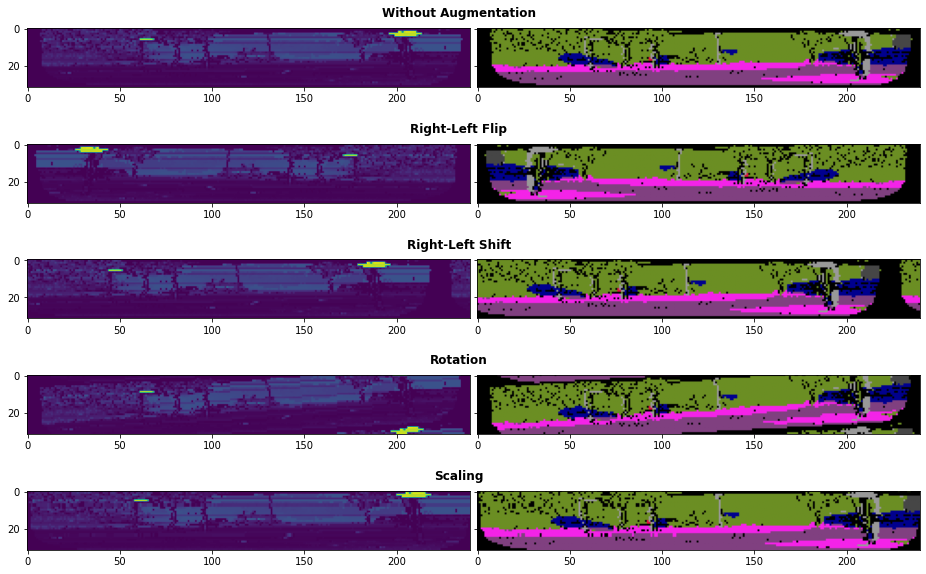

In [58]:
### Visualization of the different augmentation technique for one exemplary sample from the ika-dataset
### The intensity on the left side and the RGB encoded labels on the right side are given 

### If the value is equal to zero, the augmentation method is not used at all on the sample.
### A value greater than zero and smaller than one defines the probability of the usage of the augmentation method on the sample
### Here prob = 1.0 to definitely see results

#-! If a display error occurs and two plots do not appear four times in total, execute the cell again.

# Sample without augmentation
sample = np.load(data_paths.TRAIN.IKA[0])
rgb_encoding = segmentation_map_to_rgb_encoding(sample[:, :, 5], cfg.CLS_COLOR_MAP)

# Left-Right flip
sample_flipped = random_y_flip(sample, prob=1)
rgb_encoding_flip = segmentation_map_to_rgb_encoding(sample_flipped[:, :, 5], cfg.CLS_COLOR_MAP)

# Random shifting
sample_shift = random_shift(sample, prob=1)
rgb_encoding_shift = segmentation_map_to_rgb_encoding(sample_shift[:, :, 5], cfg.CLS_COLOR_MAP)

# Random rotation
sample_rot = random_rotate(sample, angle=10, prob=1)
rgb_encoding_rot = segmentation_map_to_rgb_encoding(sample_rot[:, :, 5], cfg.CLS_COLOR_MAP)

# Random scaling
sample_scale = random_scale(sample, zoom_bounds=(0.8, 1.2), prob=1)
rgb_encoding_scale = segmentation_map_to_rgb_encoding(sample_scale[:, :, 5], cfg.CLS_COLOR_MAP)

fig2 = plt.figure(figsize=(16, 8), constrained_layout=True)
fig2.tight_layout(pad = 0.1)

(subfig1, subfig2, subfig3, subfig4, subfig5) = fig2.subfigures(5, 1)       # create 4x1 subfigures

grid1 = ImageGrid(subfig1, 111, nrows_ncols=(1,2), axes_pad=0.1)
grid1[0].imshow(sample[:, :, 3])
grid1[1].imshow(rgb_encoding)
subfig1.suptitle('Without Augmentation', fontweight="bold", y=0.95)

grid2 = ImageGrid(subfig2, 111, nrows_ncols=(1,2), axes_pad=0.1)
grid2[0].imshow(sample_flipped[:, :, 3])
grid2[1].imshow(rgb_encoding_flip)
subfig2.suptitle('Right-Left Flip', fontweight="bold", y=0.95)

grid3 = ImageGrid(subfig3, 111, nrows_ncols=(1,2), axes_pad=0.1)
grid3[0].imshow(sample_shift[:, :, 3])
grid3[1].imshow(rgb_encoding_shift)
subfig3.suptitle('Right-Left Shift', fontweight="bold", y=0.95)

grid4 = ImageGrid(subfig4, 111, nrows_ncols=(1,2), axes_pad=0.1)
grid4[0].imshow(sample_rot[:, :, 3])
grid4[1].imshow(rgb_encoding_rot)
subfig4.suptitle('Rotation', fontweight="bold", y=0.95)

grid5 = ImageGrid(subfig5, 111, nrows_ncols=(1,2), axes_pad=0.1)
grid5[0].imshow(sample_scale[:, :, 3])
grid5[1].imshow(rgb_encoding_scale)
subfig5.suptitle('Scaling', fontweight="bold", y=0.95)

plt.show;


At this point two more functions for data preprocessing are defined. These functions will later be used to create the datasets to be used for the model.

In [59]:
def parse_sample(sample_path, augmentation, weight=None):
    """
    Parses a data sample from a file path and returns a lidar tensor, a mask tensor and a label tensor
    
    Arguments:
    sample_path -- String - File path to a sample .npy file
    augmentation -- Tuple of floats - Defines the probabilities of the augmentation functions
    weight -- Float - Weight of the sample
    
    Returns:
    lidar -- numpy ndarray of shape [height, width, 5] containing the normalized lidar data
    mask -- numpy ndarray of shape  [height, width] containing a boolean mask
    label -- numpy ndarray of shape [height, width] containing the label as segmentation map
    weight -- numpy ndarray of shape [1,] containing the weight of the sample
    """
    
    # Load numpy sample
    sample = np.load(sample_path.numpy()).astype(np.float32, copy=False)
    
    # Get original shape
    original_shape = np.shape(sample)  

    # Augmentation of the sample
    # Perform the random left-right flip augmentation
    if augmentation[0] > 0:
        sample = random_y_flip(sample, prob=augmentation[0])
    # Perform the random left-right shift augmentation
    if augmentation[1] > 0:
        sample = random_shift(sample, prob=augmentation[1])
    # Perform the random rotation augmentation
    if augmentation[2] > 0:
        sample = random_rotate(sample, prob=augmentation[2])
    # Perform the random scaling augmentation
    if augmentation[3] > 0:
        sample = random_scale(sample, prob=augmentation[3])

    # Get x, y, z, intensity, depth
    lidar = sample[:, :, :5]  
    
    # Compute binary mask: True where the depth is bigger then 0, false in any other case
    mask = lidar[:, :, 4] > 0  
    
    # Normalize input data using the mean and standard deviation
    lidar = (lidar - cfg.INPUT_MEAN) / cfg.INPUT_STD   

    # Set lidar on all channels to zero where the mask is False. Ie. where no points are present
    lidar[~mask] = 0.0  
    
    # Add Dimension to mask to obtain a tensor of shape [height, width, 1]
    mask = np.expand_dims(mask, -1)
    
    # Append mask to lidar input
    lidar = np.append(lidar, mask, axis=2)
    
    # Squeeze mask
    mask = np.squeeze(mask)
    
    # Get segmentation map from sample
    label = sample[:, :, 5]  

    # set label to None class where no points are present
    label[~mask] = cfg.CLASSES.index("None")

    # set weight
    weight = weight.numpy()

    return lidar.astype('float32'), mask.astype('bool'), label.astype('int32'), weight.astype('float32')

In [60]:
def create_dataset(sample_paths, augmentation, batch_size, weights=None, buffer_size=200):
    """
    Arguments:
    sample paths -- List of Strings which contain paths for the training samples
    batch_size -- Integer which defines the number of samples per batch
    augmentation -- Tuple of floats - Defines the probabilities of the augmentation functions
    weights -- Numpy array of the sample associated weights
    buffer_size -- Integer defines the size of the shuffle buffer
    
    Returns:
    dataset -- tf.data.Dataset
    """
    # create sample weights array if given as argument otherwise set all to 1.0
    if weights is None:
        weights = np.ones((len(sample_paths),))
    else:
        assert len(sample_paths) == len(weights)
        weights = weights

    # create a tf.data.Dataset using sample_paths
    dataset = tf.data.Dataset.from_tensor_slices((sample_paths, weights))  

    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(lambda sample, weight: tf.py_function(parse_sample, [sample, augmentation, weight], [tf.float32, tf.bool, tf.int32, tf.float32]),
                          tf.data.AUTOTUNE)
    
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size)  
    
    # Fix the input shapes by applying the function fix_shape. 
    dataset = dataset.map(lambda lidar, mask, label, weight: fix_shape(lidar, mask, label, weight, batch_size),
                          tf.data.AUTOTUNE)

    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size) 
    
    # Use prefetching for better pipeline performance. Do not modify
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

#### Network
  
The use of neural networks for semantic point cloud segmentation is currently the state-of-the-art and delivers the best results compared to other methods [[1 p.2]](https://ieeexplore.ieee.org/document/8930503). The different networks that have been developed in the past perform differently on comparable datasets. This suggests that different networks also perform differently in the context of DA. However, as this research work relates to low-level DA techniques, only one neural network is selected. For this purpose, __SqueezeSegV2__ [[7]](https://ieeexplore.ieee.org/document/8793495) is selected and implemented as an established model in the field of point cloud segmentation. Since __SqueezeSegV2__ was developed using synthetic _GTA-V_ simulation data, the model has a basically good DA performance, which is well suited for further investigations [[7 p.4379]](https://ieeexplore.ieee.org/document/8793495).  
  
Another feature of the __SqueezeSegv2__ network is that a _Focal Loss_ [[35]](https://ieeexplore.ieee.org/document/8417976) is implemented instead of a _cross entropy loss_ function. Focal loss extends cross entropy loss by a modulating factor $(1-p_{t})^{\gamma}$. With the help of the focal loss function, the unbalanced distribution of classes in LiDAR point clouds can be compensated in the scans, so that the underrepresented classes are also sufficiently taken into account during training [[7 p.4378]](https://ieeexplore.ieee.org/document/8793495).



In [61]:
def focal_loss(probabilities, lidar_mask, label, num_class, focal_gamma, denom_epislon, clf_loss_coef=15):
    """
    Compute the focal loss for semantic segmentation
    
    """
    # Cast from bool to float32 for multiplication
    lidar_mask = tf.cast(lidar_mask, tf.float32) 
    
    # Reshape label to [heigh X width]
    label = tf.reshape(label, (-1,))  # class labels
    
    # Reshape the probablity to [height X width, num_classes]
    prob = tf.reshape(probabilities, (-1, num_class))   
    
    # Add small number to avoid division by zero
    prob = prob + denom_epislon
    
    # Convert labels to onehot representation
    onehot_labels = tf.one_hot(label, depth=num_class)  
    
    # Compute the Cross Entropy (without sum) by multiplying onehot_labels with the log(prob)
    cross_entropy = tf.multiply(onehot_labels, tf.math.log(prob)) 
    
    # Compute the modulating factor of the focal loss and apply focal_gamma as exponent
    weight = (1.0 - prob) ** focal_gamma  

    # Compute the focal loss by multiplying weight with the cross_entropy
    fl = weight * cross_entropy  
    
    # Do normalization with number of valid samples and multiply with a loss coefficient
    loss = - tf.reduce_sum(fl) / tf.reduce_sum(lidar_mask) * clf_loss_coef 

    return loss

Default configuration set for the SqueezeSegV2 network.


<img src="./assets/network_structure.png" width="1000">  
  
Fig.3: Illustration of the structure of the SqueezeSegV2 network considering the input of this use case.  


In [62]:
### Configuration parameters for the neural network and the loss function
# constants
cfg.L2_WEIGHT_DECAY = 0.05
cfg.DROP_RATE = 0.1
cfg.BN_MOMENTUM = 0.9
cfg.REDUCTION = 16 #Used in CAM layer of SqueezeSeg NN

# Focal Loss Parameter
cfg.FOCAL_GAMMA = 2.0
cfg.DENOM_EPSILON = 1e-12   # small value used in denominator to prevent division by 0
cfg.CLS_LOSS_COEF = 15.0


In [63]:
class SqueezeSegV2(tf.keras.Model):
    """
    SqueezeSegV2 Model as custom Keras Model in TF 2.4
    Added the possibilty to compute sample weights in the train and test steps
    """

    def __init__(self, cfg):
        super(SqueezeSegV2, self).__init__()
        self.NUM_CLASS = cfg.NUM_CLASS
        self.CLASSES = cfg.CLASSES
        
        # input shape
        self.BATCH_SIZE = None
        self.ZENITH_LEVEL = cfg.ZENITH_LEVEL
        self.AZIMUTH_LEVEL = cfg.AZIMUTH_LEVEL
        self.NUM_FEATURES = cfg.NUM_FEATURES
        
        # regularization
        self.drop_rate = cfg.DROP_RATE
        self.l2 = cfg.L2_WEIGHT_DECAY
        self.bn_momentum = cfg.BN_MOMENTUM

        # Metrics
        self.miou_tracker = tf.keras.metrics.MeanIoU(num_classes=self.NUM_CLASS, name="MeanIoU")
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
        # Loss function
        self.loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

        # Layers
        
        # Encoder
        self.conv1 = tf.keras.layers.Conv2D(
            input_shape=[self.ZENITH_LEVEL, self.AZIMUTH_LEVEL, self.NUM_FEATURES],
            filters=64,
            kernel_size=3,
            strides=[1, 2],
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=self.bn_momentum)
        self.cam1 = CAM(in_channels=64, bn_momentum=self.bn_momentum, l2=self.l2)

        self.conv1_skip = tf.keras.layers.Conv2D(
            input_shape=[self.ZENITH_LEVEL, self.AZIMUTH_LEVEL, self.NUM_FEATURES],
            filters=64,
            kernel_size=1,
            strides=1,
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.bn1_skip = tf.keras.layers.BatchNormalization(momentum=self.bn_momentum)

        self.fire2 = FIRE(sq1x1_planes=16, ex1x1_planes=64, ex3x3_planes=64, bn_momentum=self.bn_momentum, l2=self.l2)
        self.cam2 = CAM(in_channels=128, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire3 = FIRE(sq1x1_planes=16, ex1x1_planes=64, ex3x3_planes=64, bn_momentum=self.bn_momentum, l2=self.l2)
        self.cam3 = CAM(in_channels=128, bn_momentum=self.bn_momentum, l2=self.l2)

        self.fire4 = FIRE(sq1x1_planes=32, ex1x1_planes=128, ex3x3_planes=128, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire5 = FIRE(sq1x1_planes=32, ex1x1_planes=128, ex3x3_planes=128, bn_momentum=self.bn_momentum, l2=self.l2)

        self.fire6 = FIRE(sq1x1_planes=48, ex1x1_planes=192, ex3x3_planes=192, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire7 = FIRE(sq1x1_planes=48, ex1x1_planes=192, ex3x3_planes=192, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire8 = FIRE(sq1x1_planes=64, ex1x1_planes=256, ex3x3_planes=256, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire9 = FIRE(sq1x1_planes=64, ex1x1_planes=256, ex3x3_planes=256, bn_momentum=self.bn_momentum, l2=self.l2)

        # Decoder
        self.fire10 = FIREUP(sq1x1_planes=64, ex1x1_planes=128, ex3x3_planes=128, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire11 = FIREUP(sq1x1_planes=32, ex1x1_planes=64, ex3x3_planes=64, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire12 = FIREUP(sq1x1_planes=16, ex1x1_planes=32, ex3x3_planes=32, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire13 = FIREUP(sq1x1_planes=16, ex1x1_planes=32, ex3x3_planes=32, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)

        self.conv14 = tf.keras.layers.Conv2D(
            filters=self.NUM_CLASS,
            kernel_size=3,
            strides=1,
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.dropout = tf.keras.layers.Dropout(self.drop_rate)
        
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    
    
    def call(self, inputs, training=False, mask=None):
        """
        Defines one forward pass of the network
        """
        lidar_input, lidar_mask = inputs[0], inputs[1]

        # Encoder
        x = tf.nn.relu(self.bn1(self.conv1(lidar_input)))

        cam1_output = self.cam1(x)

        conv1_skip = self.bn1_skip(self.conv1_skip(lidar_input))

        x = tf.nn.max_pool2d(cam1_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire2(x)
        x = self.cam2(x)
        x = self.fire3(x)
        cam3_output = self.cam3(x)

        x = tf.nn.max_pool2d(cam3_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire4(x)
        fire5_output = self.fire5(x)

        x = tf.nn.max_pool2d(fire5_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        fire9_output = self.fire9(x)

        # Decoder
        x = self.fire10(fire9_output)
        x = tf.add(x, fire5_output)
        x = self.fire11(x)
        x = tf.add(x, cam3_output)
        x = self.fire12(x)
        x = tf.add(x, cam1_output)
        x = self.fire13(x)
        x = tf.add(x, conv1_skip)

        x = self.dropout(x)

        logits = self.conv14(x)
        
        probabilities, predictions = self.segmentation_head(logits, lidar_mask)
        
        return probabilities, predictions

    
    def segmentation_head(self, logits, lidar_mask):
        """
        The final layer of the segmentation network which performs the final segmentation.
        """
        with tf.name_scope("segmentation_head") as scope:
            probabilities = self.softmax(logits)

            predictions = tf.argmax(probabilities, axis=-1, output_type=tf.int32)

            # set predictions to the "None" class where no points are present
            predictions = tf.where(tf.squeeze(lidar_mask),
                                   predictions,
                                   tf.ones_like(predictions) * self.CLASSES.index("None")
                                   )
        return probabilities, predictions
    
    
    def train_step(self, data):
        """
        Performs one training step which is called during model.fit()
        """
        (lidar_input, lidar_mask), label, weight = data

        with tf.GradientTape() as tape:
            probabilities, predictions = self([lidar_input, lidar_mask])  # forward pass
            # loss = self.loss_function(label, probabilities)
            loss = focal_loss(probabilities, lidar_mask, label, 
                              cfg.NUM_CLASS, cfg.FOCAL_GAMMA, cfg.DENOM_EPSILON, cfg.CLS_LOSS_COEF)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update & Compute Metrics
        with tf.name_scope("metrics") as scope:
            self.loss_tracker.update_state(loss)
            self.miou_tracker.update_state(label, predictions)
            loss_result = self.loss_tracker.result()
            miou_result = self.miou_tracker.result()
        return {'loss': loss_result, 'miou': miou_result}
    
    
    def test_step(self, data):
        """
        Performs one test step which is called during model.evaluate() and during model.fit()
        """
        (lidar_input, lidar_mask), label, weight = data

        probabilities, predictions = self([lidar_input, lidar_mask])  # forward pass

        # loss = self.loss_function(label, probabilities)
        loss = focal_loss(probabilities, lidar_mask, label, 
                                  cfg.NUM_CLASS, cfg.FOCAL_GAMMA, cfg.DENOM_EPSILON, cfg.CLS_LOSS_COEF)

        # Update Metrics
        self.loss_tracker.update_state(loss)
        self.miou_tracker.update_state(label, predictions)

        return {'loss': self.loss_tracker.result(), 'miou': self.miou_tracker.result()}

**Tuning Parameter**  

Instead of selecting the network in general, the influence of different network parameters on the DA performance is investigated. For this purpose, the following four parameters are considered in more detail:  
1.) __L2 weight decay__: In the NN, an L2 regularization term is added to the cost function to reduce generalisation: $C = C_{0} + \frac{\lambda}{2n}\sum{w^{2}}$ .The influence of different $ \lambda $ is investigated.  
2.) __Dropout rate__: Another classical regularization parameter is the dropout rate. In the considered neural network a dropout layer is implemented before the softmax layer and a changing drop rate is examined.  
3.) __Focal gamma__: As described above, the $\gamma$ parameter of the focal loss can be used to adjust the modulation of the loss function in order to take underrepresented classes into account to a greater or lesser extent in the training. A larger $\gamma$ reduces the relative loss for well-classified examples, and increases the relative loss of hard, misclassified examples. A $\gamma = 0$ would make the focal loss function equal to the cross entropy loss.  
4.) __Loss coefficient__: The loss coefficient is used to weight the loss normalised to the valid samples at the end. In this way, the influence of the loss function can be set independently of the implementation as focal loss.  
  
In principle, one could think of other possible settings for a neural network, such as selection of the optimisation algorithm or activation function. In this research work, however, we will concentrate on low-level settings and only consider parameterisations.  

#### Procedure
  
The dataset selection and compilation are compared with each other based on the training history. The individual partial examinations of the augmentation and network parameters are carried out using the iterative gridsearch methodology. The parameter to be investigated is iterated within a reasonably chosen range. In this way, the most suitable parameter can be found from this interval.  
   
For training only until the best score, an early stopping callback is also used at given points, which is defined as follows.

In [64]:
### Early stopping callback
def setEarlyStop(patience=2):
    early_stop_callback = [
        tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=patience,
            # display message when callback takes action
            verbose=1,
            # restore model weights from the epoch with the best monitored value
            restore_best_weights=True)
    ]
    cfg.EARLY_STOP = early_stop_callback


### **Experiments**

In this section, specific experiments are carried out in detail following the previously described procedure in order to examine the individual techniques and methods. The results are evaluated in the subsequent section.  
Basically, if no early stopping is set for the experiments, the epochs are limited to 10 and random 2000 samples from the larger datasets (_SemanticKITTI_ and _nuScenes_) are used for the training in order to be able to carry it out less time consuming. The limitation is legitimate for these experiments since only development trends and orders of magnitude are of interest. Finally, a fully trained model is also given for comparison at the end. This table provides an overview of the experiment parts:

|Dataset|Augmentation|Parameter|
|---|---|---|
|ika-ika|flipping|dropout rate|
|SemKITTI-ika|shifting|L2 weight decay|
|nuScenes-ika|rotation|Focal $\gamma$|
|Concatenated dataset|scaling|loss coefficient|

In [65]:
### Dict for saving the results

results = EasyDict()
# Dataset investigations in subsection
results.DATASET = {'IKA':None,
                   'KITTI':None, 
                   'NUSC':None,
                   'CON':None,
                   'NO_CON':None}
# NN parameter investigation in subsection
results.PARAM = {'BENCHMARK':None,
                 'DROP_OUT':{'X':None, 'Y':None},
                 'L2':{'X':None, 'Y':None},
                 'F_GAMMA':{'X':None, 'Y':None},
                 'COEFF':{'X':None, 'Y':None}}
# Augmentation investigation in substection
results.AUGMENTATION = {'FLIP':{'X':None, 'Y':None},
                        'SHIFT':{'X':None, 'Y':None},
                        'ROT':{'X':None, 'Y':None},
                        'SCALE':{'X':None, 'Y':None},
                        'ALL':None} 
# The augmentation results are safed in the same way as the NN params so the data evaluation becomes easier and comparable


The augmentation is initially deactivated.

In [66]:
### Disable augmentation for first investigations

augmentation = (0,    # Random Y Flip
                0,    # Random Shift
                0,    # Random Rotate
                0)    # Random Scale
#(Since py_functions unfortunately do not support dicts, the augmentation values are defined in an array)


An auxiliary function for an adjustable training is defined.

In [67]:
def training(train_paths, val_paths, cfg=cfg, augmentation=augmentation):
  """
  Helper function to combine all steps of the NN training

  Arguments:
  train_paths -- List of paths to the .npy training point cloud data
  val_paths -- List of paths to the .npy validation point cloud data
  epochs -- Number of training epochs
  cfg -- Configuration dictionary
  augmentation -- Array of the augmentation probabilities
  
  Returns:
  history -- history object of the NN training
  """
  # Select samples form training dataset and create training dataset
  if (len(train_paths) > cfg.MAX_TRAIN_SAMPLES):
    train_paths = np.random.choice(train_paths, size=cfg.MAX_TRAIN_SAMPLES)

  # set the configuration parameters depended to the selected dataset
  setConfig(train_paths)
  # create training dataset
  train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE)

  # create validation dataset
  if (len(val_paths) > cfg.MAX_VAL_SAMPLES):
    val_paths = np.random.choice(val_paths, size=cfg.MAX_VAL_SAMPLES)

  setConfig(val_paths)
  # create validation dataset
  val = create_dataset(val_paths, augmentation, batch_size=1)

  print(train,'\n',val)

  # compile the NN model
  model = SqueezeSegV2(cfg)  
  model.compile(optimizer=tf.keras.optimizers.Adam())

  # Train the dataset
  t0 = time.time()
  history = model.fit(train, validation_data=val, epochs=cfg.EPOCHS)
  t1 = time.time()
  
  print('Training time: {:.2f} sec.'.format(t1-t0))

  return history

For the dataset experimental part, the training is carried out with 2000 samples. Using larger training datasets did not change the result significantly and these partial data are sufficient to identify trends and magnitudes.

In [68]:
### Setting the number of training samples and the batch size for the following experiments

cfg.MAX_TRAIN_SAMPLES = 2000
cfg.MAX_VAL_SAMPLES = 400
cfg.BATCH_SIZE = 2
cfg.EPOCHS = 10

#### Training Dataset Choice
  
In the first experiments, the neural network is trained on the three different datasets (_ika-dataset, SemanticKITTI, NuScenes_) and validated on the ika-dataset as the target domain in each case. The ika-dataset is also validated on itself for comparison.

In [69]:
### ika - ika ###

# Select the ika training dataset
train_paths = data_paths.TRAIN.IKA 
val_paths = data_paths.VAL.IKA

results.DATASET.IKA = training(train_paths, val_paths)

<PrefetchDataset shapes: (((2, 32, 240, 6), (2, 32, 240)), (2, 32, 240), (2,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)> 
 <PrefetchDataset shapes: (((1, 32, 240, 6), (1, 32, 240)), (1, 32, 240), (1,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)>
Epoch 1/10
100/100 [==============================] - 5s 23ms/step - loss: 18.9488 - miou: 0.1540 - val_loss: 11.6718 - val_miou: 0.1989
Epoch 2/10
100/100 [==============================] - 2s 19ms/step - loss: 9.9074 - miou: 0.2337 - val_loss: 8.4689 - val_miou: 0.2689
Epoch 3/10
100/100 [==============================] - 2s 19ms/step - loss: 7.6868 - miou: 0.3019 - val_loss: 8.7272 - val_miou: 0.2452
Epoch 4/10
100/100 [==============================] - 2s 19ms/step - loss: 6.4941 - miou: 0.3297 - val_loss: 8.3650 - val_miou: 0.2835
Epoch 5/10
100/100 [==============================] - 2s 19ms/step - loss: 6.0414 - miou: 0.3427 - val_loss: 6.7956 - val_miou: 0.3241
Epoch 6/10
100/100 [==============================] -

In [70]:
### SemanticKitti - ika ###

# Select th samples from the SemanticKITTI dataset
train_paths = data_paths.TRAIN.KITTI

# ika validation set for domain shift investigation
val_paths = data_paths.VAL.IKA 

results.DATASET.KITTI = training(train_paths, val_paths)

<PrefetchDataset shapes: (((2, 32, 1024, 6), (2, 32, 1024)), (2, 32, 1024), (2,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)> 
 <PrefetchDataset shapes: (((1, 32, 240, 6), (1, 32, 240)), (1, 32, 240), (1,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)>
Epoch 1/10
1000/1000 [==============================] - 25s 20ms/step - loss: 10.5098 - miou: 0.1767 - val_loss: 121.3721 - val_miou: 0.1288
Epoch 2/10
1000/1000 [==============================] - 21s 20ms/step - loss: 7.6648 - miou: 0.2545 - val_loss: 126.4920 - val_miou: 0.1254
Epoch 3/10
1000/1000 [==============================] - 21s 20ms/step - loss: 6.9432 - miou: 0.2713 - val_loss: 121.3548 - val_miou: 0.1505
Epoch 4/10
1000/1000 [==============================] - 21s 20ms/step - loss: 6.5016 - miou: 0.2927 - val_loss: 112.1536 - val_miou: 0.1483
Epoch 5/10
1000/1000 [==============================] - 21s 20ms/step - loss: 6.1402 - miou: 0.2967 - val_loss: 108.5001 - val_miou: 0.1534
Epoch 6/10
1000/1000 [====

In [71]:
### nuScenes - ika ###

# Select the samples from the the nuScenes dataset
train_paths = data_paths.TRAIN.NUSC 

# ika validation set for domain shift investigation
val_paths = data_paths.VAL.IKA 

results.DATASET.NUSC = training(train_paths, val_paths)

<PrefetchDataset shapes: (((2, 32, 1024, 6), (2, 32, 1024)), (2, 32, 1024), (2,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)> 
 <PrefetchDataset shapes: (((1, 32, 240, 6), (1, 32, 240)), (1, 32, 240), (1,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)>
Epoch 1/10
1000/1000 [==============================] - 24s 20ms/step - loss: 8.5552 - miou: 0.2190 - val_loss: 21.6789 - val_miou: 0.1778
Epoch 2/10
1000/1000 [==============================] - 21s 20ms/step - loss: 5.9356 - miou: 0.3080 - val_loss: 21.3162 - val_miou: 0.1978
Epoch 3/10
1000/1000 [==============================] - 21s 20ms/step - loss: 5.3255 - miou: 0.3452 - val_loss: 19.5701 - val_miou: 0.2125
Epoch 4/10
1000/1000 [==============================] - 21s 20ms/step - loss: 4.8877 - miou: 0.3661 - val_loss: 17.8713 - val_miou: 0.1990
Epoch 5/10
1000/1000 [==============================] - 21s 20ms/step - loss: 4.5620 - miou: 0.3851 - val_loss: 15.1279 - val_miou: 0.2241
Epoch 6/10
1000/1000 [==========

**Target Domain Samples in Training Dataset**
  
In order to investigate the influence of adding target data to the training dataset, a composite dataset is created below, which consists of 10% samples from the target domain. These added samples are also weighted with different factors in three experiments to investigate the influence of sample weights. In contrast to the previous experiments, in this case samples from the nuScenes dataset are added to the SemanticKITTI dataset and validated on nuScenes, since the ika dataset has a different image width and thus tensor dimension due to the smaller sensor field of view. Therefore it cannot be combined with one of the other datasets to form a new dataset which is feasible for the NN. For comparison, a model is also trained and validated on the datasets without first adding target data to the training dataset.  
  
At this point it should be made clear that the target data added to the training dataset comes from the training set of the nuScenes dataset. The validation dataset is then created from the nuScenes validation set. This ensures that the same samples cannot occur in the training dataset as in the validation dataset. This would lead to a distortion of the result, as the model is biased and generally speaking simply recognises learned samples.

In [72]:
### Create new dataset with 10% samples of a different dataset
# Take random samples of the NuScenes dataset to increase performance
# The proportion is measured to the maximum training sample size so in the 'training()' function will not take a random choice

# Select datasets and proportion of target data in the final data set
add_paths = data_paths.TRAIN.NUSC
source_paths = data_paths.TRAIN.KITTI
add_prop = 0.1 # 10% proportion of traget dataset

val_paths_con = data_paths.VAL.NUSC
setConfig(val_paths_con)
val_con = create_dataset(val_paths_con, augmentation, batch_size=1)

# Investigate the influence of the sample weights of the added samples of the target dataset
res = []

for k in (1, 2, 3):
    data_paths_con, sample_weights_con = dataConcatenate(source_paths, add_paths, add_prop, k)
    setConfig(data_paths_con)
    train_con = create_dataset(data_paths_con, augmentation, weights=sample_weights_con, batch_size=cfg.BATCH_SIZE)
    print('Sample weight factor of the added dataset: ', k)

    # compile the NN model and train the dataset
    model = SqueezeSegV2(cfg)  
    model.compile(optimizer=tf.keras.optimizers.Adam())
    history = model.fit(train_con, validation_data=val_con, epochs=cfg.EPOCHS)
    res.append(history)

results.DATASET.CON = res

Size of concatenated dataset: 2000
Size of concatenated sample weight array: 2000
Sample weight factor of the added dataset:  1
Epoch 1/10
1000/1000 [==============================] - 69s 66ms/step - loss: 10.4751 - miou: 0.1985 - val_loss: 9.2628 - val_miou: 0.2375
Epoch 2/10
1000/1000 [==============================] - 66s 65ms/step - loss: 7.3187 - miou: 0.2681 - val_loss: 8.4084 - val_miou: 0.2400
Epoch 3/10
1000/1000 [==============================] - 65s 64ms/step - loss: 6.5911 - miou: 0.2923 - val_loss: 7.2556 - val_miou: 0.2680
Epoch 4/10
1000/1000 [==============================] - 66s 64ms/step - loss: 6.0825 - miou: 0.3010 - val_loss: 7.3322 - val_miou: 0.2699
Epoch 5/10
1000/1000 [==============================] - 66s 65ms/step - loss: 5.7617 - miou: 0.3103 - val_loss: 7.5526 - val_miou: 0.2627
Epoch 6/10
1000/1000 [==============================] - 66s 64ms/step - loss: 5.4062 - miou: 0.3189 - val_loss: 6.7559 - val_miou: 0.2907
Epoch 7/10
1000/1000 [=====================

Comparison training with the same datasets but without adding target data to the training dataset.

In [73]:
### SemanticKITTI - NuScenes ###

# Select the samples from the the NuScenes dataset
train_paths = data_paths.TRAIN.KITTI 

# NuScenes validation set for concatenation investigation
val_paths = data_paths.VAL.NUSC 

results.DATASET.NO_CON = training(train_paths, val_paths)

<PrefetchDataset shapes: (((2, 32, 1024, 6), (2, 32, 1024)), (2, 32, 1024), (2,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)> 
 <PrefetchDataset shapes: (((1, 32, 1024, 6), (1, 32, 1024)), (1, 32, 1024), (1,)), types: ((tf.float32, tf.bool), tf.int32, tf.float32)>
Epoch 1/10
1000/1000 [==============================] - 26s 23ms/step - loss: 10.3256 - miou: 0.1902 - val_loss: 85.3192 - val_miou: 0.0968
Epoch 2/10
1000/1000 [==============================] - 23s 22ms/step - loss: 7.8884 - miou: 0.2531 - val_loss: 117.6599 - val_miou: 0.0983
Epoch 3/10
1000/1000 [==============================] - 23s 22ms/step - loss: 6.9813 - miou: 0.2738 - val_loss: 120.4477 - val_miou: 0.0998
Epoch 4/10
1000/1000 [==============================] - 23s 22ms/step - loss: 6.4231 - miou: 0.2837 - val_loss: 106.3396 - val_miou: 0.1004
Epoch 5/10
1000/1000 [==============================] - 23s 22ms/step - loss: 5.9807 - miou: 0.2978 - val_loss: 96.5490 - val_miou: 0.1015
Epoch 6/10
1000/1000 [===

**Parameter Tuning**
  
In the following, the nuScenes dataset is used as the initial domain. Since a gridsearch is performed over the respective parameter arrays for the next experiments, the total number of training epochs increases significantly, since several epochs are trained per selected parameter. To speed this up a little, in the following we will only train on 250 random samples and set the early stopping callback. A comparison result with standard parameters and without augmentation is also be given. 250 samples are sufficient to be able to recognise trends in the results for different parameters, since the result of the comparison data set with 250 training samples differs only minimally from the model previously trained on 2000 samples.

In [74]:
### Configure and create the dataset
# data paths
train_paths = data_paths.TRAIN.NUSC
val_paths = data_paths.VAL.IKA

# general configuration parameters
cfg.MAX_TRAIN_SAMPLES = 250
cfg.MAX_VAL_SAMPLES = 50
cfg.BATCH_SIZE = 1
setEarlyStop(patience=1)
cfg.EPOCHS = 50 # Set high since early stopping enabled

# set the configuration parameters depended to the selected dataset
if (len(train_paths) > cfg.MAX_TRAIN_SAMPLES):
    train_paths = np.random.choice(train_paths, size=cfg.MAX_TRAIN_SAMPLES)

setConfig(train_paths)
# create training dataset
train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE)

if (len(val_paths) > cfg.MAX_VAL_SAMPLES):
    val_paths = np.random.choice(val_paths, size=cfg.MAX_VAL_SAMPLES)

setConfig(val_paths)
# create validation dataset
val = create_dataset(val_paths, augmentation, batch_size=1)


Benchmark model training for comparision without parameter optimization.

In [75]:
### Benchmark model with standard parameter for comparision
# Training on only 250 trainings samples

# Configuration standard parameters
cfg.L2_WEIGHT_DECAY = 0.05
cfg.DROP_RATE = 0.1
# Focal Loss Parameter
cfg.FOCAL_GAMMA = 2.0
cfg.CLS_LOSS_COEF = 15.0

model = SqueezeSegV2(cfg)  
model.compile(optimizer=tf.keras.optimizers.Adam())

# Train the dataset
t0 = time.time()
history = model.fit(train, validation_data=val, epochs=cfg.EPOCHS, callbacks=cfg.EARLY_STOP)
t1 = time.time()

results.PARAM.BENCHMARK = history


Epoch 1/50
250/250 [==============================] - 8s 19ms/step - loss: 13.3281 - miou: 0.1579 - val_loss: 16.3265 - val_miou: 0.1587
Epoch 2/50
250/250 [==============================] - 5s 17ms/step - loss: 8.4528 - miou: 0.2394 - val_loss: 16.3246 - val_miou: 0.1737
Epoch 3/50
250/250 [==============================] - 5s 17ms/step - loss: 7.5163 - miou: 0.2713 - val_loss: 20.5346 - val_miou: 0.1402
Epoch 4/50
250/250 [==============================] - 5s 17ms/step - loss: 7.1989 - miou: 0.2658 - val_loss: 18.3887 - val_miou: 0.1897
Epoch 5/50
250/250 [==============================] - 5s 17ms/step - loss: 6.8658 - miou: 0.3007 - val_loss: 19.3611 - val_miou: 0.2032
Epoch 6/50
250/250 [==============================] - 5s 17ms/step - loss: 6.6345 - miou: 0.2915 - val_loss: 18.3922 - val_miou: 0.1936
Epoch 7/50
250/250 [==============================] - 5s 17ms/step - loss: 6.4178 - miou: 0.2951 - val_loss: 16.5782 - val_miou: 0.2175
Epoch 8/50
250/250 [===========================

**Dropout rate**

In [76]:
### Grid search of the best drop rate

metrics = []

# Define parameter array
param = np.arange(0.1, 0.9, 0.1) # Drop rate needs to be smaller than 1
#param = [0.1, 0.9] 
print('Parameter array of Drop Rate: ', param)

for i in param:
    cfg.DROP_RATE = i
    model = SqueezeSegV2(cfg)  
    model.compile(optimizer=tf.keras.optimizers.Adam())
    print('Drop Rate: ', i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val)) 

#Store the parameter and results
results.PARAM.DROP_OUT.Y = metrics
results.PARAM.DROP_OUT.X = param


Parameter array of Drop Rate:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
Drop Rate:  0.1
Restoring model weights from the end of the best epoch: 13.
Epoch 00014: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 20.8861 - miou: 0.2072
Drop Rate:  0.2
Restoring model weights from the end of the best epoch: 7.
Epoch 00008: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 25.5097 - miou: 0.1888
Drop Rate:  0.30000000000000004
Restoring model weights from the end of the best epoch: 8.
Epoch 00009: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 23.4043 - miou: 0.1963
Drop Rate:  0.4
Restoring model weights from the end of the best epoch: 9.
Epoch 00010: early stopping
50/50 [==============================] - 1s 5ms/step - loss: 31.0450 - miou: 0.1790
Drop Rate:  0.5
Restoring model weights from the end of the best epoch: 12.
Epoch 00013: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 26.06

**L2 Weight Decay**

In [77]:
### Grid search of the best L2 weight

metrics = []

# Define parameter array
param = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1]  # standard: 0.05 
# param = [0.001, 0.1]
print('Parameter array of L2 Weight: ', param)

for i in param:
    cfg.L2_WEIGHT_DECAY = i
    model = SqueezeSegV2(cfg)  
    model.compile(optimizer=tf.keras.optimizers.Adam())
    print('L2 Weight: ', i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val))

#Store the parameter and results
results.PARAM.L2.Y = metrics
results.PARAM.L2.X = param

Parameter array of L2 Weight:  [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1]
L2 Weight:  0.001
Restoring model weights from the end of the best epoch: 14.
Epoch 00015: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 25.1820 - miou: 0.2006
L2 Weight:  0.0025
Restoring model weights from the end of the best epoch: 13.
Epoch 00014: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 25.5132 - miou: 0.2232
L2 Weight:  0.005
Restoring model weights from the end of the best epoch: 15.
Epoch 00016: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 23.2740 - miou: 0.2228
L2 Weight:  0.0075
Restoring model weights from the end of the best epoch: 15.
Epoch 00016: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 22.8017 - miou: 0.2064
L2 Weight:  0.01
Restoring model weights from the end of the best epoch: 7.
Epoch 00008: early stopping
50/50 [==============================] - 

**Focal $\gamma$**

In [78]:
### Grid search of the best Focal loss gamma parameter

metrics = []

# Define parameter array
param = np.arange(0, 6.5, 0.5) # standard: 2.0
# param = [0, 6.5]
print('Parameter array of Focal Gamma: ', param)

for i in param:
    cfg.FOCAL_GAMMA = i
    model = SqueezeSegV2(cfg)  
    model.compile(optimizer=tf.keras.optimizers.Adam())
    print('Focal Loss Gamma: ', i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val))

#Store the parameter and results
results.PARAM.F_GAMMA.Y = metrics
results.PARAM.F_GAMMA.X = param

Parameter array of Focal Gamma:  [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
Focal Loss Gamma:  0.0
Restoring model weights from the end of the best epoch: 12.
Epoch 00013: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 37.9502 - miou: 0.1986
Focal Loss Gamma:  0.5
Restoring model weights from the end of the best epoch: 1.
Epoch 00002: early stopping
50/50 [==============================] - 1s 6ms/step - loss: nan - miou: 0.1303
Focal Loss Gamma:  1.0
Restoring model weights from the end of the best epoch: 9.
Epoch 00010: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 28.3923 - miou: 0.1896
Focal Loss Gamma:  1.5
Restoring model weights from the end of the best epoch: 11.
Epoch 00012: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 29.3797 - miou: 0.1708
Focal Loss Gamma:  2.0
Restoring model weights from the end of the best epoch: 14.
Epoch 00015: early stopping
50/50 [=====================

**Loss Coefficient**

In [79]:
### Grid search of the best loss coefficient

metrics = []

# Define parameter array
param = np.arange(2.5, 32.5, 2.5) # standard: 15
# param = [1, 30] 
print('Parameter array of Loss Coefficient: ', param)

for i in param:
    cfg.CLS_LOSS_COEF = i
    model = SqueezeSegV2(cfg)  
    model.compile(optimizer=tf.keras.optimizers.Adam())
    print('Loss Coefficient: ', i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val))

#Store the parameter and results
results.PARAM.COEFF.Y = metrics
results.PARAM.COEFF.X = param
    

Parameter array of Loss Coefficient:  [ 2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30. ]
Loss Coefficient:  2.5
Restoring model weights from the end of the best epoch: 8.
Epoch 00009: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 2.0391 - miou: 0.1978
Loss Coefficient:  5.0
Restoring model weights from the end of the best epoch: 14.
Epoch 00015: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 4.1405 - miou: 0.2016
Loss Coefficient:  7.5
Restoring model weights from the end of the best epoch: 11.
Epoch 00012: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 6.9744 - miou: 0.1865
Loss Coefficient:  10.0
Restoring model weights from the end of the best epoch: 16.
Epoch 00017: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 9.7478 - miou: 0.2101
Loss Coefficient:  12.5
Restoring model weights from the end of the best epoch: 12.
Epoch 00013: early stopping
50/50 [=====

#### Augmentation

Finally, we examine the different augmentation methods. We again take the nuScenes dataset as the source domain and only train on 250 samples. The threshold values of the augmentation methods, such as maximum and minimum angle during rotation or maximum and minimum scaling factor, have been reasonably constrained beforehand and are not changed for the experiments. The respective parameter for each sample is randomly selected between these limit values during the dataset creation. In the following experiments, the probability that the respective augmentation method is used on a sample is investigated. This is iterated in 10% steps from no usage (0%) to a usage on each sample (100%).

In [80]:
### Configure and create the dataset
# Make sure the augmentation is disabled in the first place
augmentation = (0,    # Random Y Flip
                0,    # Random Shift
                0,    # Random Rotate
                0)    # Random Scale

# general configuration parameters
cfg.MAX_TRAIN_SAMPLES = 250
cfg.MAX_VAL_SAMPLES = 50
cfg.BATCH_SIZE = 1
setEarlyStop(patience=2)
cfg.EPOCHS = 20

# Select training and validation dataset
train_paths = data_paths.TRAIN.NUSC 
val_paths = data_paths.VAL.IKA

# Select samples from the datasets
if (len(train_paths) > cfg.MAX_TRAIN_SAMPLES):
    train_paths = np.random.choice(train_paths, size=cfg.MAX_TRAIN_SAMPLES)
if (len(val_paths) > cfg.MAX_VAL_SAMPLES):
    val_paths = np.random.choice(val_paths, size=cfg.MAX_VAL_SAMPLES)

# Compile the neural network
model = SqueezeSegV2(cfg)  
model.compile(optimizer=tf.keras.optimizers.Adam())



**Y Flipping**

In [81]:
### Augmentation grid search
metrics = []

# Define parameter array
param = np.arange(0, 1.1, 0.1)
# param = [0, 0.9]
print('Parameter array of the probability: ', param)

for i in param:
    augmentation = (i, 0, 0, 0)

    setConfig(train_paths)
    train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE)
    setConfig(val_paths)
    val = create_dataset(val_paths, augmentation, batch_size=1)
    print('Y-Flip augmentation probability: ',i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val))

#Store the parameter and results
results.AUGMENTATION.FLIP.X = param
results.AUGMENTATION.FLIP.Y = metrics

Parameter array of the probability:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Y-Flip augmentation probability:  0.0
Restoring model weights from the end of the best epoch: 18.
Epoch 00020: early stopping
50/50 [==============================] - 1s 6ms/step - loss: 26.6262 - miou: 0.2152
Y-Flip augmentation probability:  0.1
Restoring model weights from the end of the best epoch: 17.
Epoch 00019: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 23.1293 - miou: 0.2180
Y-Flip augmentation probability:  0.2
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 25.7880 - miou: 0.2198
Y-Flip augmentation probability:  0.30000000000000004
Restoring model weights from the end of the best epoch: 3.
Epoch 00005: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 25.5265 - miou: 0.2190
Y-Flip augmentation probability:  0.4
Restoring model weights f

**Shifting**

In [82]:
### Augmentation grid search
metrics = []

# Define parameter array
param = np.arange(0, 1.1, 0.1)
# param = [0, 0.9]
print('Parameter array of the probability: ', param)

for i in param:
    augmentation = (0, i, 0, 0)

    setConfig(train_paths)
    train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE)
    setConfig(val_paths)
    val = create_dataset(val_paths, augmentation, batch_size=1)
    print('Shift augmentation probability: ',i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val))

#Store the parameter and results
results.AUGMENTATION.SHIFT.X = param
results.AUGMENTATION.SHIFT.Y = metrics

Parameter array of the probability:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Shift augmentation probability:  0.0
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 22.9498 - miou: 0.2372
Shift augmentation probability:  0.1
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 25.0961 - miou: 0.2349
Shift augmentation probability:  0.2
Restoring model weights from the end of the best epoch: 3.
Epoch 00005: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 25.4173 - miou: 0.2151
Shift augmentation probability:  0.30000000000000004
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 25.4403 - miou: 0.2204
Shift augmentation probability:  0.4
Restoring model weights from the

**Rotation**

In [83]:
### Augmentation grid search
metrics = []

# Define parameter array
param = np.arange(0, 1.1, 0.1)
# param = [0, 0.9]
print('Parameter array of the probability: ', param)

for i in param:
    augmentation = (0, 0, i, 0)

    setConfig(train_paths)
    train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE)
    setConfig(val_paths)
    val = create_dataset(val_paths, augmentation, batch_size=1)
    print('Rotation augmentation probability: ',i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val))

#Store the parameter and results
results.AUGMENTATION.ROT.X = param
results.AUGMENTATION.ROT.Y = metrics

Parameter array of the probability:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Rotation augmentation probability:  0.0
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 26.1142 - miou: 0.1964
Rotation augmentation probability:  0.1
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 23.8846 - miou: 0.2088
Rotation augmentation probability:  0.2
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 25.5871 - miou: 0.2242
Rotation augmentation probability:  0.30000000000000004
Restoring model weights from the end of the best epoch: 7.
Epoch 00009: early stopping
50/50 [==============================] - 0s 5ms/step - loss: 23.3758 - miou: 0.2420
Rotation augmentation probability:  0.4
Restoring model w

**Scaling**

In [84]:
### Augmentation grid search
metrics = []

# Define parameter array
param = np.arange(0, 1.1, 0.1)
# param = [0, 1.0]
print('Parameter array of the probability: ', param)

for i in param:
    augmentation = (0, 0, 0, i)

    setConfig(train_paths)
    train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE)
    setConfig(val_paths)
    val = create_dataset(val_paths, augmentation, batch_size=1)
    print('Scaling augmentation probability: ',i)
    model.fit(train, epochs=cfg.EPOCHS, verbose=0, callbacks=cfg.EARLY_STOP)
    metrics.append(model.evaluate(val))

#Store the parameter and results
results.AUGMENTATION.SCALE.X = param
results.AUGMENTATION.SCALE.Y = metrics

Parameter array of the probability:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Scaling augmentation probability:  0.0
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 22.4424 - miou: 0.2113
Scaling augmentation probability:  0.1
Restoring model weights from the end of the best epoch: 3.
Epoch 00005: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 24.1714 - miou: 0.2042
Scaling augmentation probability:  0.2
Restoring model weights from the end of the best epoch: 5.
Epoch 00007: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 26.2737 - miou: 0.2029
Scaling augmentation probability:  0.30000000000000004
Restoring model weights from the end of the best epoch: 1.
Epoch 00003: early stopping
50/50 [==============================] - 0s 6ms/step - loss: 25.5155 - miou: 0.2192
Scaling augmentation probability:  0.4
Restoring model weight

**All together**  
Finally, the interaction of the augmentation methods is examined in order to validate whether certain methods influence each other. For this purpose, the probabilities are set around the mean value of 50% and distributed according to the best parameters determined beforehand.

In [85]:
# Best probabilities of the augmentation functions when executed individually
augmentation = (0.6,    # Y-Flip
                0.5,    # Shift
                0.4,    # Rotate
                0.7)    # Scale

cfg.EPOCHS = 10

setConfig(train_paths)
train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE)
setConfig(val_paths)
val = create_dataset(val_paths, augmentation, batch_size=1)

history = model.fit(train, validation_data=val, epochs=cfg.EPOCHS)


#Store the parameter and results
results.AUGMENTATION.ALL = history

Epoch 1/10
250/250 [==============================] - 5s 17ms/step - loss: 2.8249 - miou: 0.4235 - val_loss: 26.5582 - val_miou: 0.2084
Epoch 2/10
250/250 [==============================] - 5s 17ms/step - loss: 2.4685 - miou: 0.4246 - val_loss: 20.1797 - val_miou: 0.2133
Epoch 3/10
250/250 [==============================] - 5s 17ms/step - loss: 2.3440 - miou: 0.4452 - val_loss: 23.5959 - val_miou: 0.2220
Epoch 4/10
250/250 [==============================] - 5s 17ms/step - loss: 2.4694 - miou: 0.4367 - val_loss: 23.9658 - val_miou: 0.2116
Epoch 5/10
250/250 [==============================] - 5s 17ms/step - loss: 2.4767 - miou: 0.4296 - val_loss: 25.6350 - val_miou: 0.1957
Epoch 6/10
250/250 [==============================] - 5s 17ms/step - loss: 2.5117 - miou: 0.4200 - val_loss: 25.8745 - val_miou: 0.2120
Epoch 7/10
250/250 [==============================] - 5s 17ms/step - loss: 2.3879 - miou: 0.4576 - val_loss: 28.9812 - val_miou: 0.1983
Epoch 8/10
250/250 [============================

### **Evaluation**

In this section, the previously obtained results are visualised, analysed and compared in order to derive implementation recommendations on this basis. Basically, two parameters are used for the evaluation. Firstly, the loss during training and validation is considered in order to be able to classify how well the model worked on the respective datasets. The loss can also be used to recognise when overfitting occurs, as from this point the loss to be minimised would increase again. However, this cannot always be observed with a few epochs and these statements should therefore be treated with caution. The second parameter used is the Mean Intersection over Union (MIoU). This is based on the comparison of the predictions with the labels and is the standard metric for investigating segmentation performance. The IoU is defined as follows:  
  
<img src="./assets/miou_basics.png" width="400">
  
Fig.4: Definition of the Intersection over Union (IoU) metric
  


In [86]:
### Define a dict to store the evaluation results

# Best dataset and parameter for the NN and the augmentation functions gather by the experiments
best_param = EasyDict({'DATASET':None,
                       'DROP_OUT':None,
                       'L2':None,
                       'F_GAMMA':None,
                       'COEFF':None,
                       'FLIP':None,
                       'SHIFT':None,
                       'ROT':None,
                       'SCALE':None})


Two auxiliary functions are defined for the evaluation of the various results.

In [87]:
def print_history(history):
  """
  Helper function to show results after the training of a NN

  Arguments:
  history -- History object as the return of the training function
    
  Returns:
  min_val_miou_id -- Epoch number with lowest lowest validation loss (starting at 1)
  val_loss -- Validation loss at the epoch with the lowest val loss
  val_miou -- Validation MeanIoU at the epoch with the lowest val loss
  """

  # Evaluate smallest validation loss
  max_val_miou_id = np.argmax(history.history['val_miou'])+1
  min_val_loss_id = np.argmin(history.history['val_loss'])+1
  epochs = len(history.history['val_miou'])
  
  # Plot
  fig = plt.figure(figsize=(16, 8))
  (ax1, ax2) = fig.subplots(2)
  plt.subplots_adjust()
  axes = plt.gca()
  ax1.plot(range(1,epochs+1),history.history['loss'], 'b', linestyle='dashed')
  ax1.plot(range(1,epochs+1),history.history['val_loss'], 'b')
  ax2.plot(range(1,epochs+1),history.history['miou'], 'g', linestyle='dashed')
  ax2.plot(range(1,epochs+1),history.history['val_miou'], 'g')
  ylim = ax1.get_ylim()
  ax1.vlines(min_val_loss_id, ylim[0], ylim[1], 'r', ':')
  ax1.set_xticks(ticks = range(1,epochs+1))
  ax2.set_xticks(ticks = range(1,epochs+1))
  ax1.set_title("Loss over epochs", fontweight='bold')
  ax2.set_title("MeanIoU over epochs", fontweight='bold')
  ax1.legend(['training loss', 'validation loss', 'start of overfitting'],bbox_to_anchor=(1.04,0.5), loc="center left")
  ax2.legend(['training MeanIoU', 'validation MeanIoU'],bbox_to_anchor=(1.04,0.5), loc="center left")
  plt.show()

  # return values
  val_loss = history.history['val_loss'][max_val_miou_id-1]
  val_miou = history.history['val_miou'][max_val_miou_id-1]

  return max_val_miou_id, val_loss, val_miou

In [88]:
def print_metrics(metrics, rot_label=None):
  """
  Helper function to show results after the training of a NN

  Arguments:
  metrics -- metrics array as the return of the evaluation function
    
  Returns:
  best_param -- Value of investigated parameter with best results regarding to the MeanIoU (starting at 1)
  val_loss -- Validation loss with the best parameter
  val_miou -- Validation MeanIoU with the best parameter
  """

  # Find the best parameter in the metrics array
  miou_arr = np.asarray(metrics.Y)[:,1]
  loss_arr = np.asarray(metrics.Y)[:,0]
  param_arr = metrics.X
  best_param = np.around(param_arr[np.argmax(miou_arr)], decimals=1)

  # plot
  fig = plt.figure(figsize=(16, 10))
  (ax1, ax2) = fig.subplots(2)
  plt.subplots_adjust()
  axes = plt.gca()
  ax1.plot(param_arr,loss_arr, 'b')
  ax2.plot(param_arr,miou_arr, 'g')

  ylim = ax2.get_ylim()
  ax2.vlines(best_param, ylim[0], miou_arr[np.argmax(miou_arr)], 'r', ':')
  ax1.set_xticks(ticks = param_arr)
  ax2.set_xticks(ticks = param_arr)
  ax1.set_title("Loss over parameter variation", fontweight='bold')
  ax2.set_title("MeanIoU over parameter variation", fontweight='bold')
  if rot_label is not None: 
    for a in (ax1, ax2): plt.setp(a.get_xticklabels(), rotation=30, horizontalalignment='right')
  plt.show()

  # return values
  val_loss = loss_arr[np.argmax(miou_arr)]
  val_miou = miou_arr[np.argmax(miou_arr)]

  return best_param, val_loss, val_miou

#### Dataset
  
Since the data set experiments were conducted on a constant 10 epochs, in this case the training with validation histories are plotted over the epochs. 

**ika - ika**

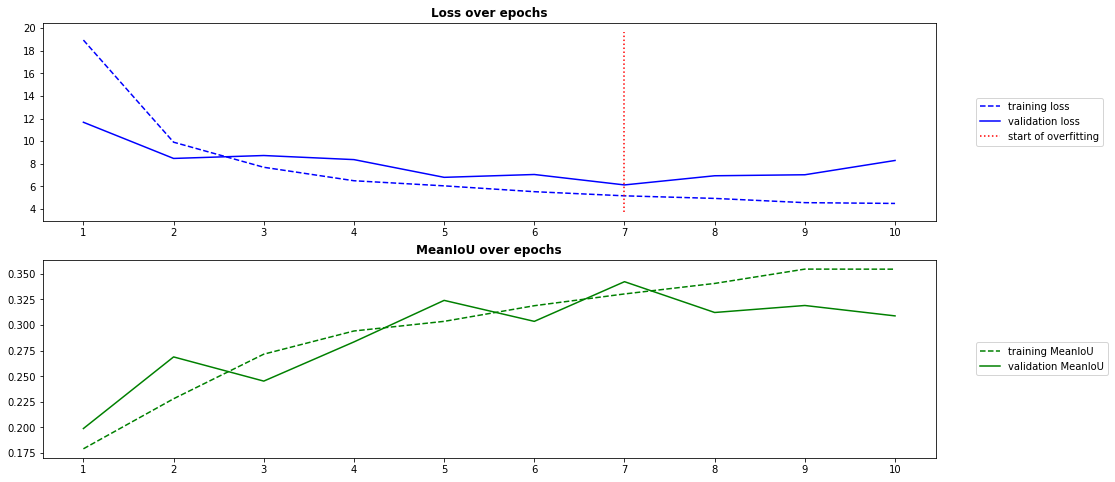

After # 7 epochs the best training was achieved with an val. MeanIoU of 0.34239447116851807


In [89]:
### ika - ika ###
res_ika = print_history(results.DATASET.IKA)
print('After #', res_ika[0], 'epochs the best training was achieved with an val. MeanIoU of', res_ika[2])

**SemanticKITTI - ika**

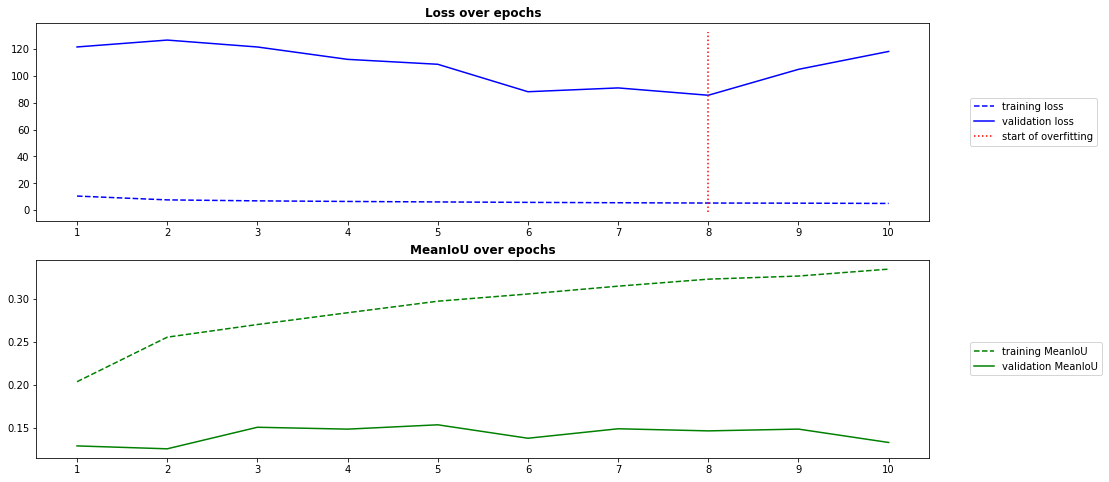

After # 5 epochs the best training was achieved with an val. MeanIoU of 0.15335965156555176


In [90]:
### SemanticKITTI - ika ###
res_kitti = print_history(results.DATASET.KITTI)
print('After #', res_kitti[0], 'epochs the best training was achieved with an val. MeanIoU of', res_kitti[2])

**nuScenes - ika**

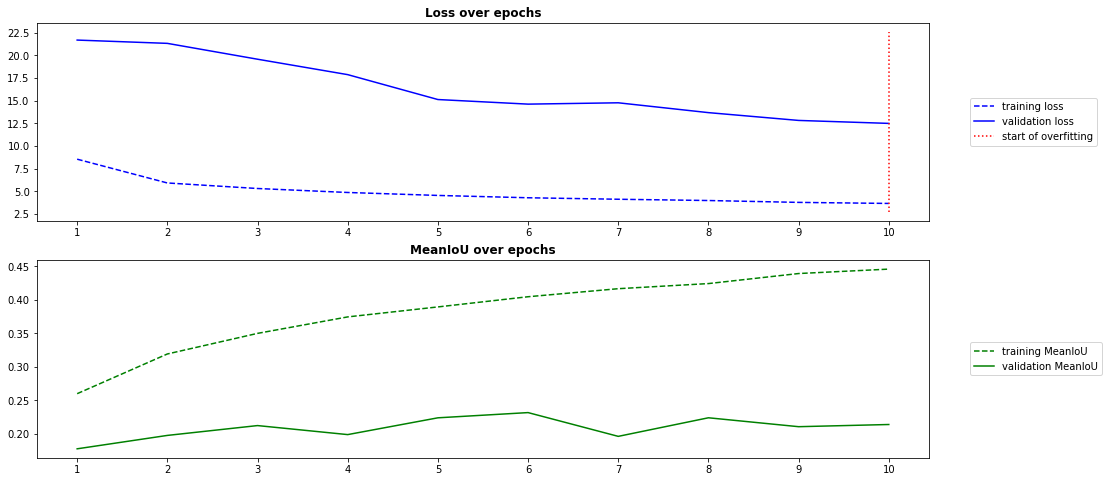

After # 6 epochs the best training was achieved with an val. MeanIoU of 0.23185032606124878


In [91]:
### nuScenes - ika ###
res_nusc = print_history(results.DATASET.NUSC)
print('After #', res_nusc[0], 'epochs the best training was achieved with an val. MeanIoU of', res_nusc[2])

Here, in the experiments where the source and target datasets differ completely, the discrepancy between the loss and MIoU values makes the different performance on foreign datasets particularly clear. It can also be seen that the choice of the training dataset has a significant impact on the DA performance, as the model trained on nuScenes performs significantly better than the model trained on SemanticKITTI. From this point of view, when the structure and setup of the datasets presented in the Methodology section is considered again, no obvious correlation can be found. Taking into account the country where the point cloud data was recorded, it would suggest that the model trained on SemanticKITTI performs better than the model trained on nuScenes, but this is not the case. SemanticKITTI and the ika-dataset were both generated in Germany, while nuScenes does not contain any data samples from Germany. One hypothesis that can be raised is that the model with the nuScenes training set performs better in terms of domain shift to the ika-dataset scene due to the significantly larger number of different scenes.   

**Investigation training with different sample weights for concatenated datasets**

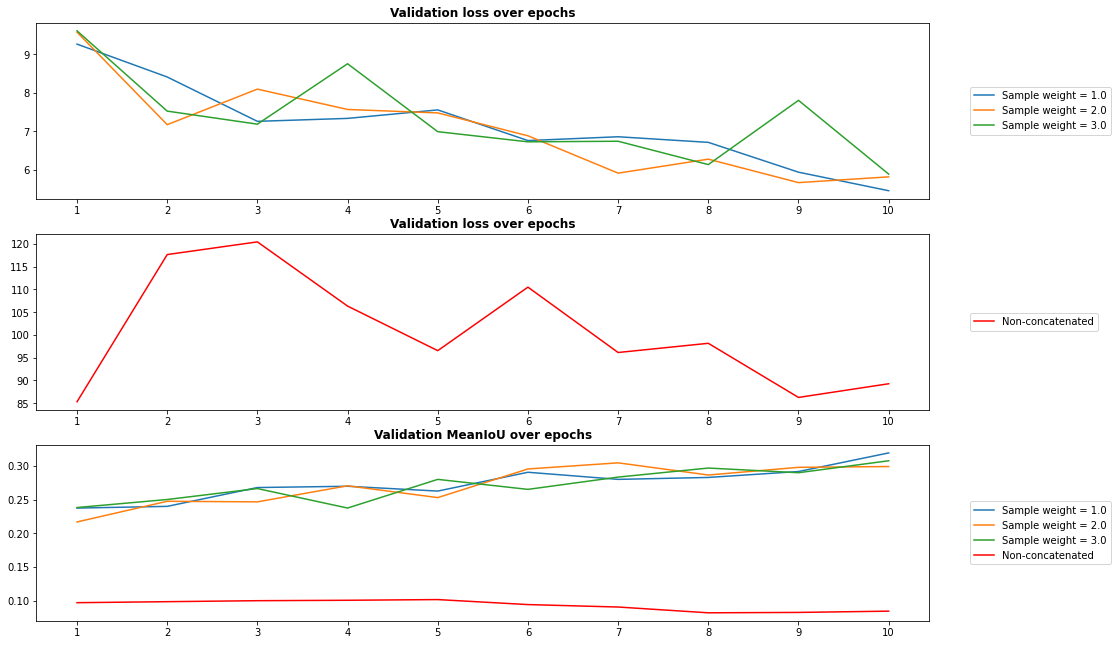

In [92]:
### Concatenated SemanticKitti + NuScenes - NuScenes ###
fig = plt.figure(figsize=(16, 11))
(ax1, ax2, ax3) = fig.subplots(3)
plt.subplots_adjust()
axes = plt.gca()
epochs = len(results.DATASET.CON[0].history['val_miou'])

for j in np.arange(len(results.DATASET.CON)):
    his = results.DATASET.CON[j]
    ax1.plot(range(1, epochs+1), his.history['val_loss'])
    ax3.plot(range(1, epochs+1), his.history['val_miou'])

# Add the plots of without concatenation
# Since the loss size of the training with the non-concatenated dataset is significantly larger it is shown in an extra plot.
ax2.plot(range(1, epochs+1), results.DATASET.NO_CON.history['val_loss'], 'r')
ax3.plot(range(1, epochs+1), results.DATASET.NO_CON.history['val_miou'], 'r')

# Set titles and legends
ax1.set_title('Validation loss over epochs', fontweight='bold')
ax2.set_title('Validation loss over epochs', fontweight='bold')
ax3.set_title("Validation MeanIoU over epochs", fontweight='bold')
ax1.legend(['Sample weight = 1.0', 'Sample weight = 2.0', 'Sample weight = 3.0'],bbox_to_anchor=(1.04,0.5), loc="center left")
ax2.legend(['Non-concatenated'],bbox_to_anchor=(1.04,0.5), loc="center left")
ax3.legend(['Sample weight = 1.0', 'Sample weight = 2.0', 'Sample weight = 3.0', 'Non-concatenated'],bbox_to_anchor=(1.04,0.5), loc="center left")
ax1.set_xticks(ticks = range(1,epochs+1))
ax2.set_xticks(ticks = range(1,epochs+1))
ax3.set_xticks(ticks = range(1,epochs+1))

plt.show()

The upper plot shows very clearly the role of target data in the training dataset. Regardless of the weighting of the added target samples, the performance of models trained on merged datasets is about three times better than the comparison model in red, although only 10% of the samples come from the target dataset. It can also be seen very clearly that the weighting factor only plays a subordinate role, since the performance does not differ significantly between the different weightings.  

In [93]:
best_param.DATASET = data_paths.TRAIN.NUSC

#### Parameter Tuning  
  
First, the comparative model, which was also trained on the smaller data set of 250 samples, is presented analogously to the previous experiments. It can be seen that the reduction of the training samples from 2000 to 250 samples does not have a great influence, as both models have a maximum MIoU of about 0.2.

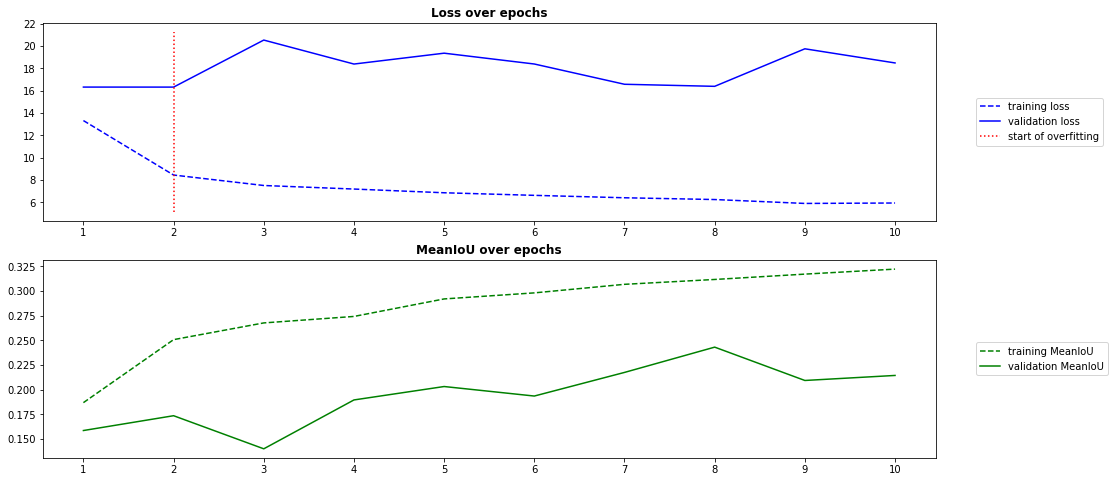

After # 8 epochs the best training was achieved with an val. MeanIoU of 0.2431279718875885


In [110]:
### Benchmark model for comparision
# Model with standard parameters and without augmentation

# NuScenes - ika (250 training samples)
res_bench = print_history(results.PARAM.BENCHMARK)
print('After #', res_bench[0], 'epochs the best training was achieved with an val. MeanIoU of', res_bench[2])

In the network and loss function parameter experiments the models were trained iteratively over a parameter array. Therefore, the metrics are plotted over the parameter arrays in the following. Since no overfitting can be examined with this procedure the maximum MIoU value is marked instead.

**Dropout Rate**

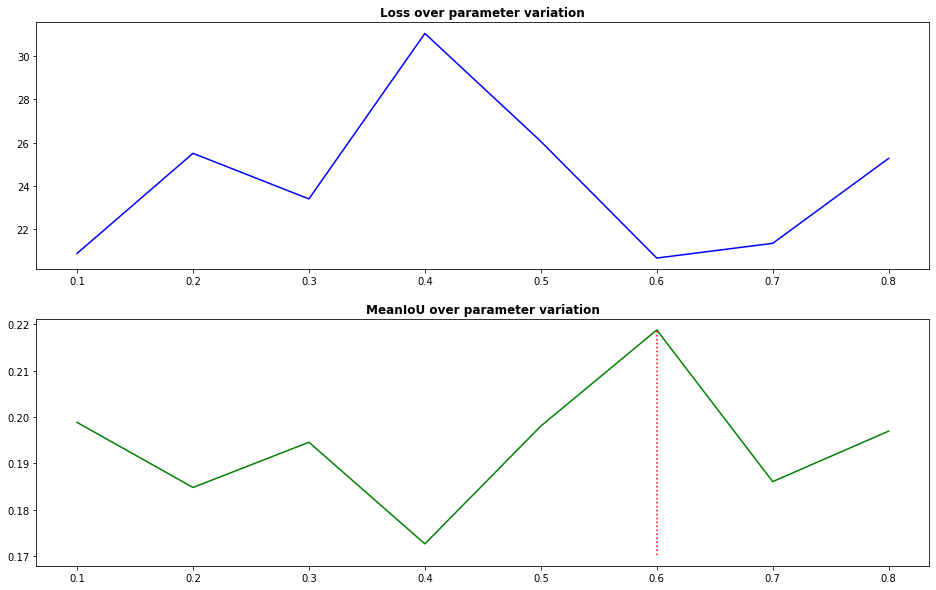

At a Drop Out Rate of 0.6 the best training was achieved with an val. MeanIoU of 0.21879538893699646


In [111]:
### Drop rate
res = print_metrics(results.PARAM.DROP_OUT)
print('At a Drop Out Rate of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.DROP_OUT = res[0]

**L2 Regularization: weight decay**

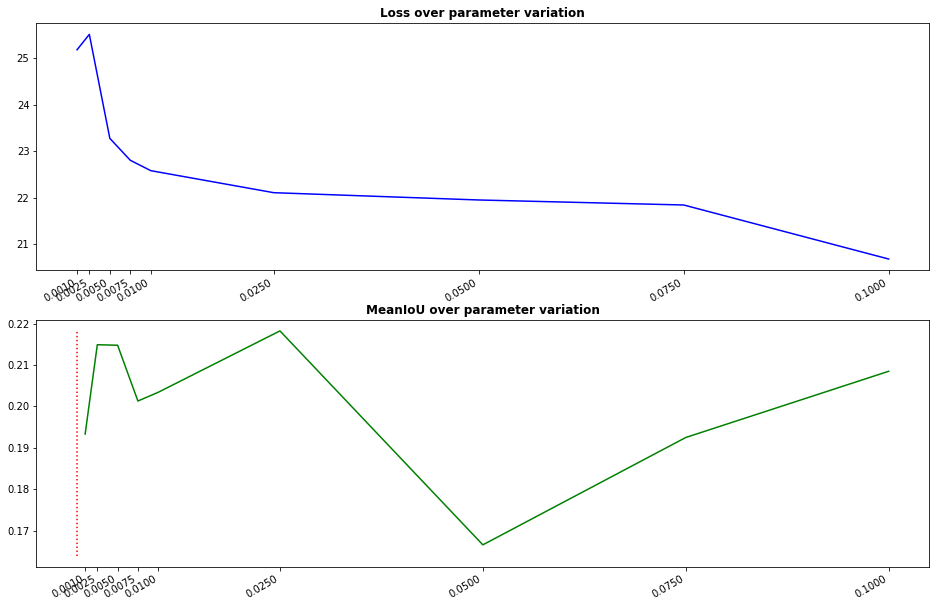

At a L2-weight value of 0.0 the best training was achieved with an val. MeanIoU of 0.21824444830417633


In [112]:
### L2 weight decay
res = print_metrics(results.PARAM.L2, rot_label=True)
print('At a L2-weight value of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.L2 = res[0]

**Focal loss $\gamma$**

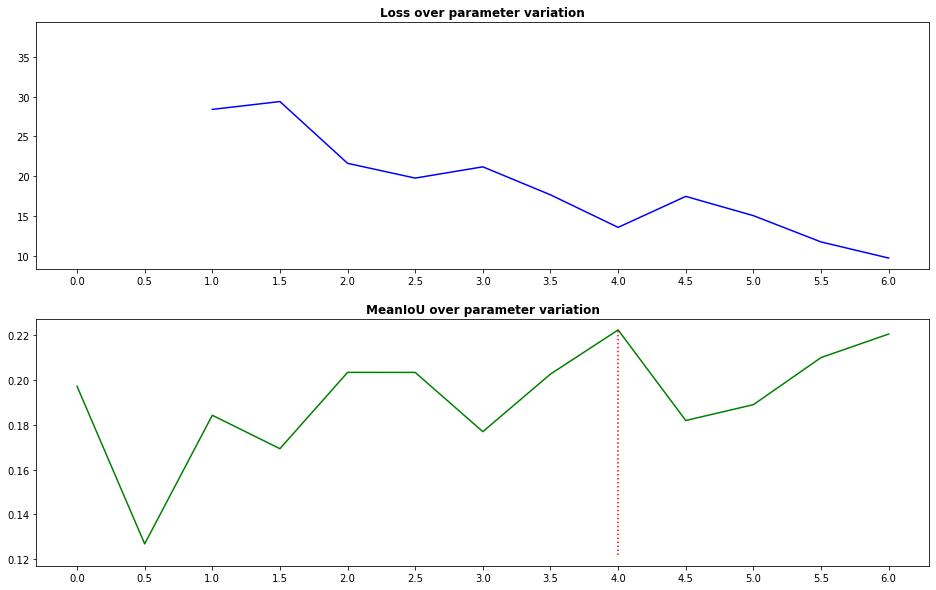

At a Focal gamma of 4.0 the best training was achieved with an val. MeanIoU of 0.2223864495754242


In [113]:
### Focal loss gamma
res = print_metrics(results.PARAM.F_GAMMA)
print('At a Focal gamma of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.F_GAMMA = res[0]

**Loss Coefficient**

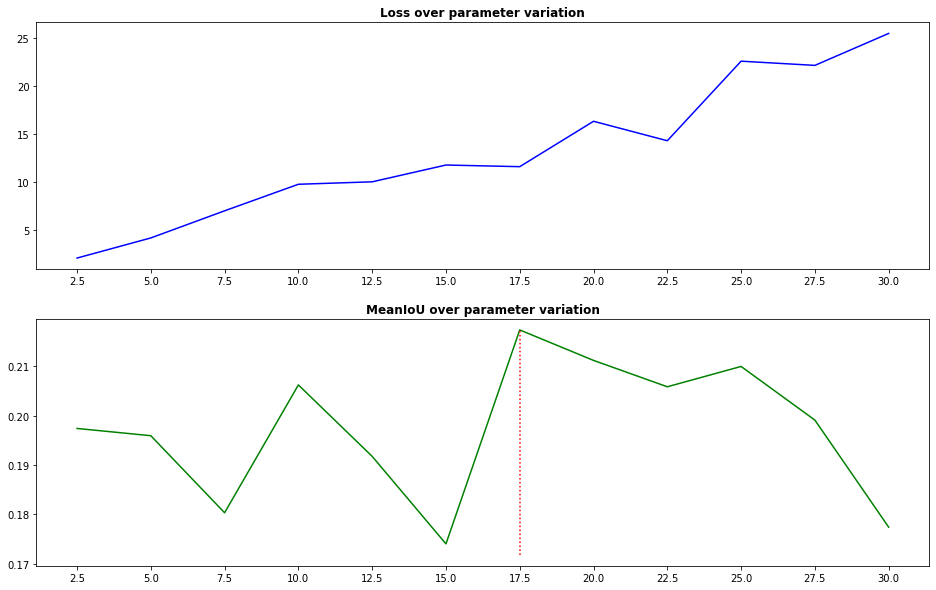

At a Loss coefficient of 17.5 the best training was achieved with an val. MeanIoU of 0.21737267076969147


In [114]:
### Loss coefficient
res = print_metrics(results.PARAM.COEFF)
print('At a Loss coefficient of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.COEFF = res[0]

In all plots above it can be seen that the results fluctuate significantly depending on the parameter and in some cases it is difficult to recognise a trend. Especially the MIoU value jumps from small to large values in sections with small parameter changes. This behaviour can be observed particularly well in the results for L2 regularization at the initial values, since minimum and maximum MIoU values alternate in this area. It can be concluded from this that fine-tuning these parameters does not result in any clear improvements in performance. Since several local maxima occur in the MIoU curves, the corresponding loss value should be taken into account when selecting the parameter. A local maximum with a slightly lower MIoU value than the global maximum sometimes results in a significant reduction of the loss. This can be clearly seen, for example, in the plot of the loss coefficient.

#### Augmentation
  
The augmentation methods are evaluated analogously to the parameter experiments and the metrics are plotted over the probability arrays.

**Flipping**

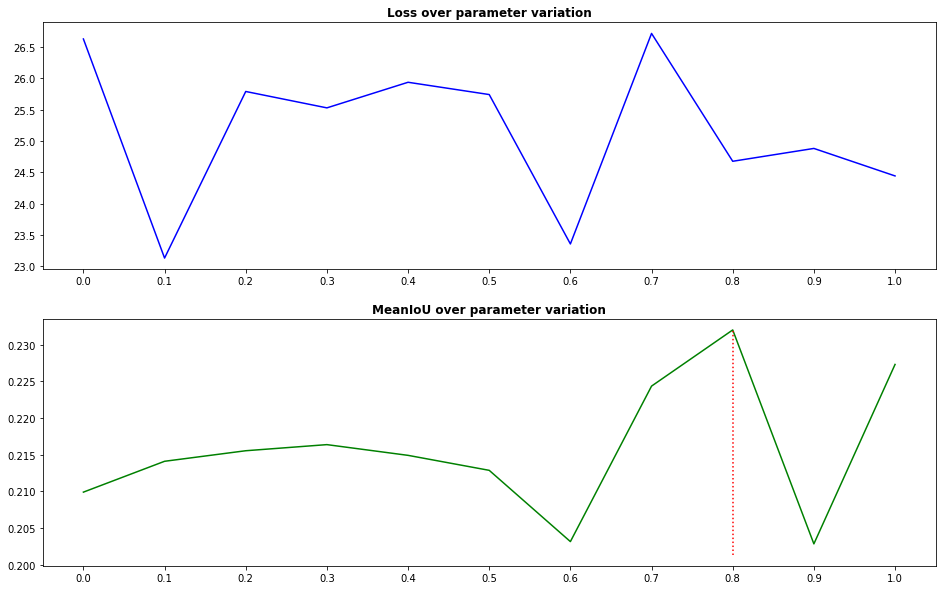

At a Left-Right-Flip probability of 0.8 the best training was achieved with an val. MeanIoU of 0.23199516534805298


In [115]:
### Left-right flip
res = print_metrics(results.AUGMENTATION.FLIP)
print('At a Left-Right-Flip probability of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.FLIP = res[0]

**Shifting**

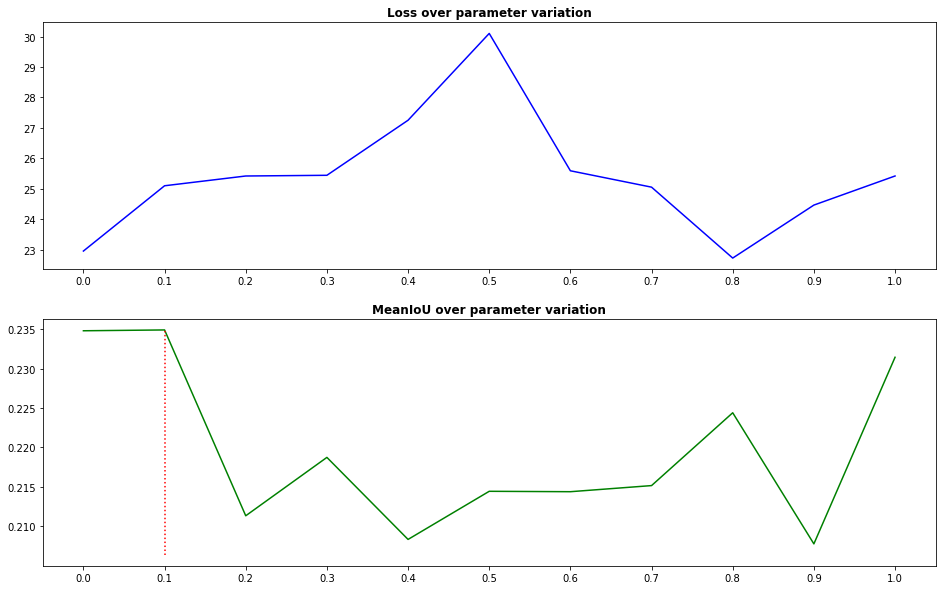

At a Left-Right-Shift probability of 0.1 the best training was achieved with an val. MeanIoU of 0.23489107191562653


In [116]:
### Shifting
res = print_metrics(results.AUGMENTATION.SHIFT)
print('At a Left-Right-Shift probability of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.SHIFT = res[0]

**Rotation**

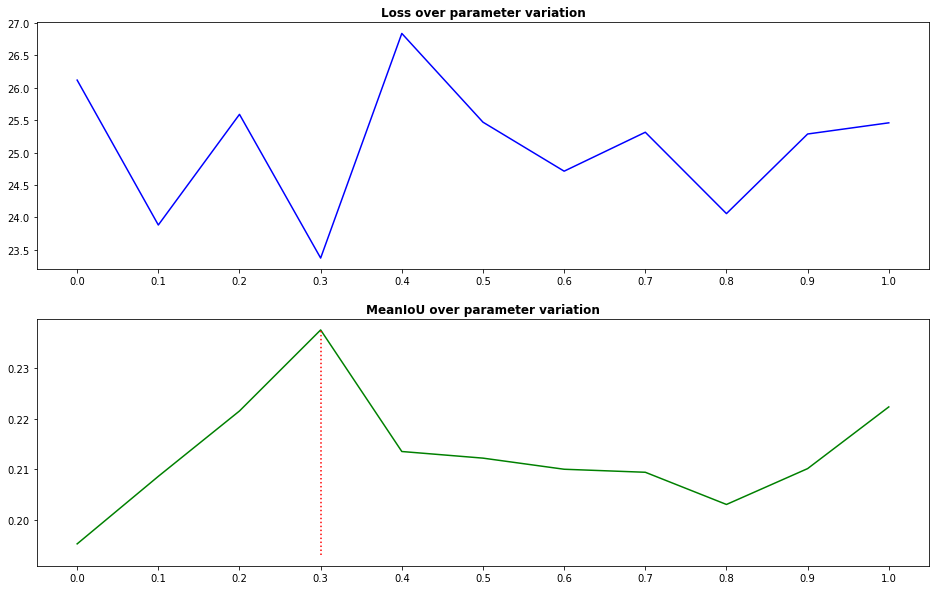

At a Rotation augmentation probability of 0.3 the best training was achieved with an val. MeanIoU of 0.23761214315891266


In [117]:
### Rotation
res = print_metrics(results.AUGMENTATION.ROT)
print('At a Rotation augmentation probability of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.ROT = res[0]

**Scaling**

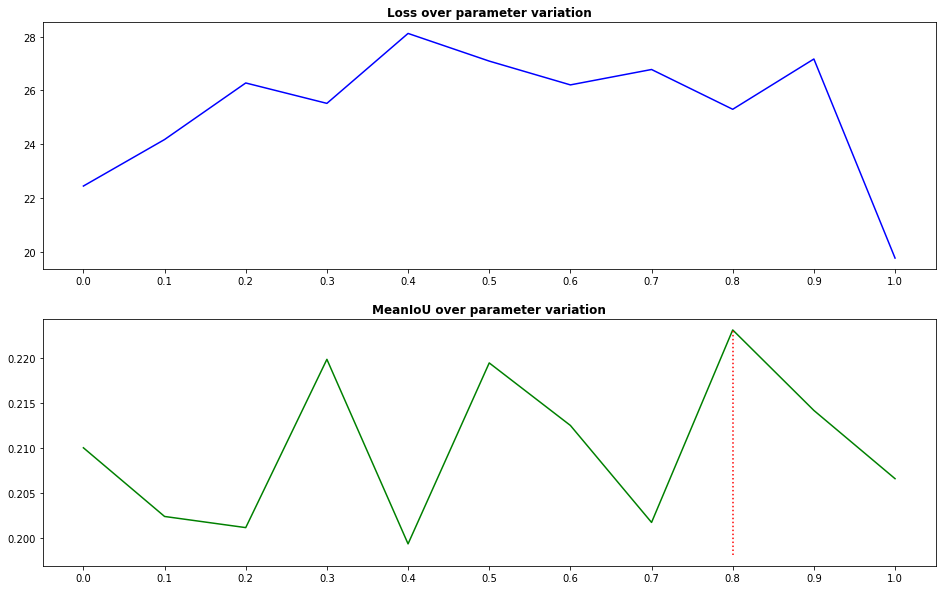

At a Scaling augmentation probability of 0.8 the best training was achieved with an val. MeanIoU of 0.22310079634189606


In [118]:
### Scaling
res = print_metrics(results.AUGMENTATION.SCALE)
print('At a Scaling augmentation probability of',res[0], 'the best training was achieved with an val. MeanIoU of', res[2])
best_param.SCALE = res[0]

The plots of the augmentation methods show a similar behaviour to the parameter results. Several local maxima can be seen across the probability arrays and in some sections there are clear jumps in the MIoU values. Here, too, it can be concluded that the augmentation methods have no significant influence on the basic DA performance, since the MIoU values fluctuate approximately around a mean value over the probability array and no clear trend is identifiable. In sections, a trend can be approximated by a maximum. The resulting best probability is determined on these trends.

**Combination of Augmentation methods**

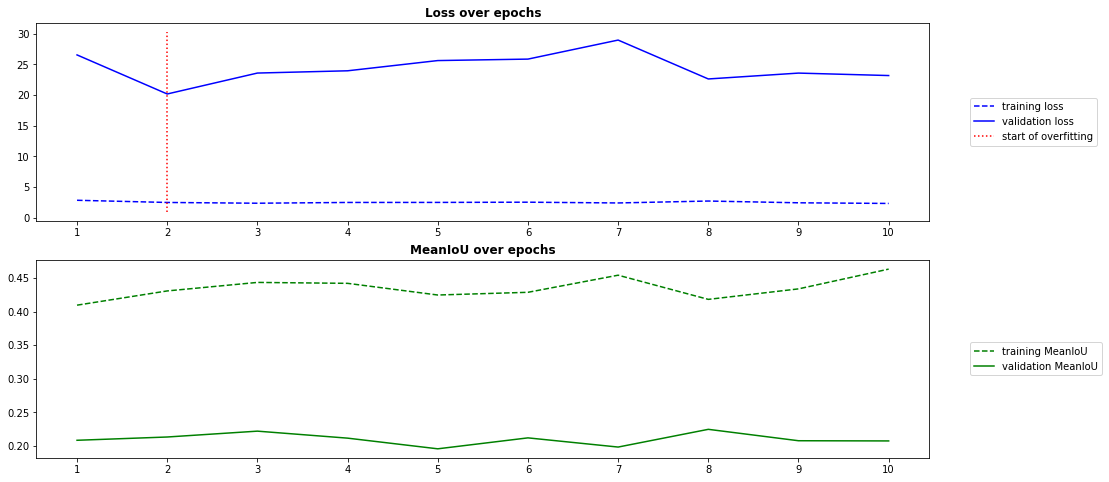

After # 8 epochs the best training was achieved with an val. MeanIoU of 0.22473634779453278


In [119]:
### All together
res = print_history(results.AUGMENTATION.ALL)
print('After #',res[0], 'epochs the best training was achieved with an val. MeanIoU of', res[2])

When all augmentation methods are considered together in combination, it can be seen that augmentation cannot reduce the discrepancy between the training and validation scores, but even increases it. This is due to the fact that augmentation significantly improves the training result, but does not improve the DA performance in validation. The validation MIoU, which represents the DA performance, has remained in the range of 0.2 compared to the benchmark model. The training MIoU, which is obtained by the evaluation function on the source dataset, however, increases from approx. 0.33 in the comparison model to over 0.5. This proves that the augmentation methods work and improve the training result but have no significant influence with regard to domain adaptation.  

#### Final holistic Model
  
In this subsection, the previously determined implementation recommendations will be analysed in the form of the determined best parameters using a complete, holistic model. For this purpose, a model with these parameters is trained on the complete dataset with an early stopping patience of 2. Since this training can take a long time due to the size of the data set, it is possible to load pre-trained weights of this model in the following.  
It should be noted at this point that it was previously observed that the DA performance can best be improved with merged datasets. However, this case will be excluded here, as it turns out to be difficult in practice to have data of the target domain available during model training.

In [121]:
# If the parameters have not been compiled or problems have occurred, the parameters can also be loaded at this point
# read_dictionary = np.load('best_param.npy',allow_pickle='TRUE').item()
# best_param = read_dictionary

In [122]:
### Print the final parameter results of the evaluation

print('Best values for Semantic Point Cloud Segmentation with SqueezeSegV2:\n')
print('Dataset:          nuScenes Dataset')
print('Parameter')
print('Drop-out rate:   ', best_param.DROP_OUT)
print('L2 weight decay: ', best_param.L2)
print('Focal gamma:     ', best_param.F_GAMMA)
print('CLS loss coeff:  ', best_param.COEFF)
print('Augmentation')
print('Y-Flip:          ', best_param.FLIP)
print('Shifting:        ', best_param.SHIFT)
print('Rotation:        ', best_param.ROT)
print('Scaling:         ', best_param.SCALE)




Best values for Semantic Point Cloud Segmentation with SqueezeSegV2:

Dataset:          nuScenes Dataset
Parameter
Drop-out rate:    0.6
L2 weight decay:  0.0
Focal gamma:      4.0
CLS loss coeff:   17.5
Augmentation
Y-Flip:           0.8
Shifting:         0.1
Rotation:         0.3
Scaling:          0.8


In [123]:
### !-- You have the option to train and save your own model or just load the given model --! ###
### Therefore uncomment your decision and comment out the opposite in the following:

# dec = 'train+save'
dec = 'load'



Total Parameters DA model:  932010


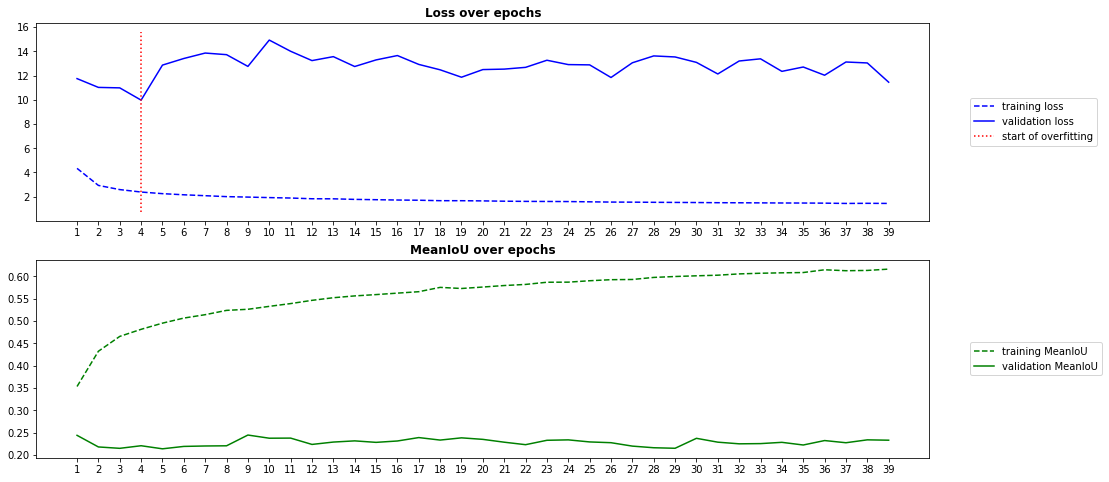

In [124]:
### Create datasets and compute the final model

if(dec == 'train+save'):

    # Select the best dataset
    train_paths = best_param.DATASET
    val_paths = data_paths.TRAIN.IKA # Training dataset is selected to have more validation samples

    # general configuration parameters
    cfg.MAX_TRAIN_SAMPLES = 100000 # set high so the whole dataset is used and no choice is applied
    cfg.MAX_VAL_SAMPLES = 100000
    cfg.BATCH_SIZE = 4
    cfg.EPOCHS = 50 # Set high since early stopping enabled
    setEarlyStop(patience=2)

    # Select the best parameter
    cfg.DROP_RATE = best_param.DROP_OUT
    cfg.L2_WEIGHT_DECAY = best_param.L2
    cfg.FOCAL_GAMMA = best_param.F_GAMMA
    cfg.CLS_LOSS_COEF = best_param.COEFF

    # Select the best augmentation values
    augmentation = (best_param.FLIP, 
                    best_param.SHIFT, 
                    best_param.ROT, 
                    best_param.SCALE)

    # Dataset-dependent configuration and dataset creation
    setConfig(train_paths)
    train = create_dataset(train_paths, augmentation, batch_size=cfg.BATCH_SIZE) 
    setConfig(val_paths)
    val = create_dataset(val_paths, augmentation, batch_size=1)
    print(train,'\n',val)

    # Compile the NN
    model_da = SqueezeSegV2(cfg)  
    model_da.compile(optimizer=tf.keras.optimizers.Adam())

    # Train and save the model
    t0 = time.time()
    history = model_da.fit(train, validation_data=val, epochs=cfg.EPOCHS, callbacks=cfg.EARLY_STOP)
    t1 = time.time()
    print('Training time: {:.2f} sec.'.format(t1-t0))
    _ = print_history(history)
    # Save
    !mkdir -p saved_models/train_save
    model_da.save_weights('saved_models/train_save/final_model_weights') # Save model weights
    model_da.save('saved_models/train_save/final_model') # save whole model
    np.save('saved_models/train_save/history.npy', history)

elif(dec == 'load'):
    # Load and evaluate the model
    mod = tf.keras.models.load_model('saved_models/load/final_mod');
    total_params = np.sum([np.prod(v.get_shape()) for v in mod.trainable_weights]) + np.sum([np.prod(v.get_shape()) for v in mod.non_trainable_weights])
    print("Total Parameters DA model: ", int(total_params))
    display(Image(filename='saved_models/load/final_da_model.png'))

    train_paths = data_paths.TRAIN.IKA[0:10]
    augmentation = (0, 0, 0, 0)
    setConfig(train_paths)
    train = create_dataset(train_paths, augmentation, batch_size=1) 

    model_da = SqueezeSegV2(cfg)
    model_da.compile(optimizer=tf.keras.optimizers.Adam())
    # The model needs to be fitted to prevent error messages due to unused checkpoints
    model_da.fit(train, epochs=2, verbose=0)
    model_da.load_weights('saved_models/load/final_model_weights')

else: print('Please choose a valid option (train+save or load) in the cell above')


Benchmark model trained on SemanticKitti dataset


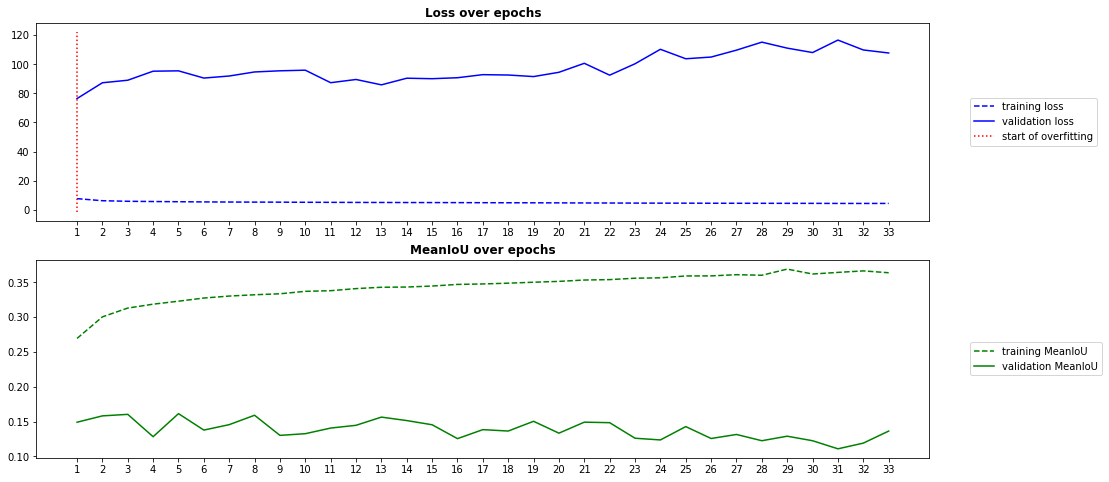

Benchmark model trained on nuScenes dataset


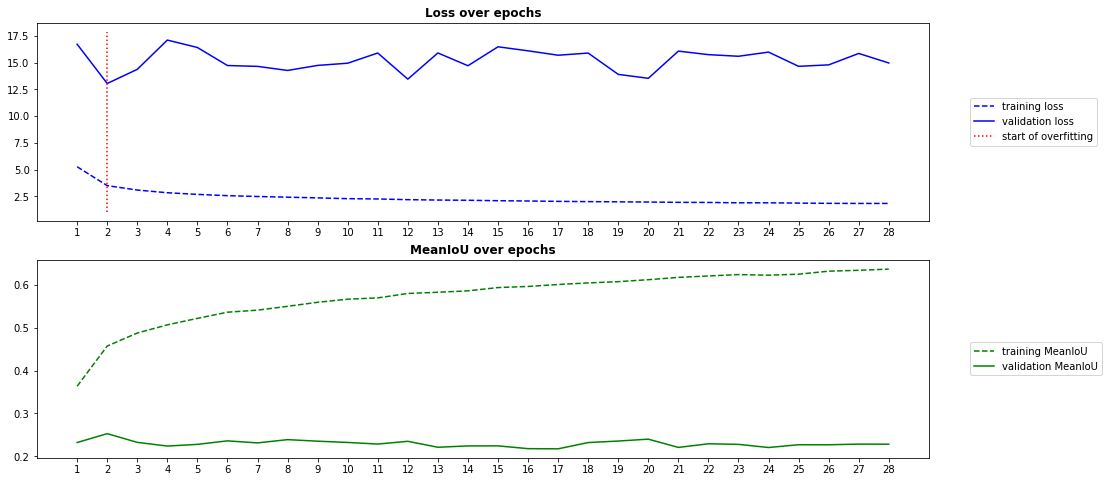

In [125]:
### Load benchmark models

# Standard Parameter SqueezeSegV2/Focal loss for benchmark models:
cfg.DROP_RATE = 0.1
cfg.L2_WEIGHT_DECAY = 0.05
cfg.FOCAL_GAMMA = 2.0
cfg.CLS_LOSS_COEF = 15.0

train_paths = data_paths.TRAIN.IKA[0:10]
augmentation = (0, 0, 0, 0)
setConfig(train_paths)
train = create_dataset(train_paths, augmentation, batch_size=1) 

# The models must be created separately as the custom SqueezeSegV2 model class for example cannot be cloned.
model_bench_kitti = SqueezeSegV2(cfg)
model_bench_nusc = SqueezeSegV2(cfg)
model_bench_kitti.compile(optimizer=tf.keras.optimizers.Adam())
model_bench_nusc.compile(optimizer=tf.keras.optimizers.Adam())
# The model needs to be fitted to prevent error messages due to unused checkpoints
model_bench_kitti.fit(train, epochs=2, verbose=0)
model_bench_nusc.fit(train, epochs=2, verbose=0)

print("Benchmark model trained on SemanticKitti dataset")
model_bench_kitti.load_weights('saved_models/benchmark/benchmark_model_weights')
display(Image(filename='saved_models/benchmark/bench_model.png'))

print("Benchmark model trained on nuScenes dataset")
model_bench_nusc.load_weights('saved_models/benchmark2/benchmark_model_weights')
display(Image(filename='saved_models/benchmark2/bench2_model.png'))

When looking at the fully trained models, it can be seen that the discrepancy between the training MIoU of the optimised model and the comparison model disappears with longer training with more data. Both models of which training set is based on the nuScenes dataset achieve a training MIoU of about 0.6. The DA performance cannot be improved even with longer training. Only the comparison between the DA-optimised model and the comparison model trained on the SemanticKITTI confirms the influence of the selection of the initial data set on the basic DA performance.  
  
For a deeper analysis using the Confusion Matrix, auxiliary functions are again defined.  

In [126]:
def visuPredictionLabel(data_paths, model):
    """
    Visualizes the segmentation prediction and label of three dataset samples in RGB encoding

    Arguments:
    data_paths -- List of paths to the .npy point cloud data
    model -- model object of SqueezeSegV2 class
    """
    # Initialize the plot
    print('%-*s %-*s %s' % (25,' ', 60,'Predictions', 'Labels'))
    fig = plt.figure(figsize=(16, 16)) 
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(3, 2),
                    axes_pad=0.1,
                    )


    for k in range(3):
        lidar, mask, label, weight = parse_sample(tf.constant(data_paths[k*30]), (0,0,0,0), weight=tf.constant(1))
        # Add batch dimension
        lidar = tf.expand_dims(lidar, axis=0)
        mask = tf.expand_dims(mask, axis=0)

        probabilities, predictions = model([lidar, mask])

        # Remove batch dimension
        predictions = tf.squeeze(predictions)
        lidar = tf.squeeze(lidar)
        # Plot image
        image = segmentation_map_to_rgb_encoding(predictions.numpy(), cfg.CLS_COLOR_MAP)
        grid[k*2].imshow(image)

        image = segmentation_map_to_rgb_encoding(label, cfg.CLS_COLOR_MAP)
        grid[k*2+1].imshow(image)

    plt.show()

In [128]:
def computeConfMat(dataset, model):
  """
  Computes the Confusion Matrix, Precision value array and Recall value array of a created dataset with the given model

  Arguments:
  dataset -- created dataset from the data paths
  model -- model object of SqueezeSegV2 class
  
  Return:
  conf_mat -- matrix with the Confusion values for each class of the dataset
  """
  # Initialize MIoU metric
  miou = tf.metrics.MeanIoU(num_classes=cfg.NUM_CLASS)

  for j in dataset:
      (lidar, mask), label, weight = j
      probability, prediction = model([lidar, mask]) 
      miou.update_state(label, prediction)
      
  # Confusion matrix
  conf_mat = miou.total_cm
  # Calculate TP, FP, FN for Precision and Recall
  tp = np.diag(conf_mat)
  fp = np.sum(conf_mat, axis=0) - tp
  fn = np.sum(conf_mat, axis=1) - tp

  precision = tf.math.divide_no_nan(tp, tp + fp)
  recall = tf.math.divide_no_nan(tp, tp + fn)

  # print the results
  print('%-*s %-*s %s' % (13, 'Class', 15, 'Precision', 'Recall'))
  for id, cl in enumerate(cfg.CLASSES):
    print('%-*s: %-*s: %s' % (13, cl, 15, precision.numpy()[id], recall.numpy()[id]))

  return conf_mat

In [129]:
def plotConfMat(conf_mat):
    """
    Plots the normalized Confusion Matrix as a heatmap

    Arguments:
    conf_mat -- confusion matrix
    """

    # Normalize Matrix (Broadcasting)
    row_sums = np.sum(conf_mat, axis=1)
    conf_mat_norm = conf_mat / row_sums[:, np.newaxis]

    # Initialize plot
    plt.figure(figsize = (16, 16))
    ax = sns.heatmap(conf_mat_norm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix with labels\n\n', fontweight='bold')
    plt.xlabel('\nPredicted Values', fontweight='bold')
    plt.ylabel('Actual Values ', fontweight='bold')

    ## Ticket labels - List must be in alphabetical order
    tick_marks = np.arange(len(cfg.CLASSES))+0.5
    plt.xticks(tick_marks, cfg.CLASSES, rotation=45);
    plt.yticks(tick_marks, cfg.CLASSES);
    #plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha="left")

    plt.show()

In a final step, we want to look at the specific values of a DA analysis instead of the plots. To do this, we will compare the fully trained models on the SemanticKITTI and nuScenes datasets as well as the optimised DA model obtained in the experiments, which is based on the nuScenes dataset.

In [130]:
### Compare Loss and MIoU values in fact of DA
# In order to have more validation samples, the ika training set is used instead of the smaller validation set

# Create the validation dataset for evaluation
val_paths = data_paths.TRAIN.IKA
setConfig(val_paths)
val = create_dataset(val_paths, augmentation, batch_size=1) 

# Load weights and evaluate
eval_bench_kitti = model_bench_kitti.evaluate(val, verbose=0)
eval_bench_nusc = model_bench_nusc.evaluate(val, verbose=0)
eval_da = model_da.evaluate(val, verbose=0)

# Print results
print("%-*s %-*s %-*s %-*s" % (5, ' ', 20, 'Bench (SemKITTI)', 20, 'Bench (nuScenes)', 20, 'DA'))
print("Loss: %-*f %-*f %-*f" % (20, eval_bench_kitti[0], 20, eval_bench_nusc[0], 20, eval_da[0]))
print("MIoU: %-*f %-*f %-*f" % (20, eval_bench_kitti[1], 20, eval_bench_nusc[1], 20, eval_da[1]))


      Bench (SemKITTI)     Bench (nuScenes)     DA                  
Loss: 116.634911           14.784507            14.996030           
MIoU: 0.110925             0.226921             0.222571            


The evaluation results of the three models confirm the statements made above. At this point, however, it is interesting that the DA model even achieves a slightly worse DA performance than the nuScenes comparison model despite supposedly optimised parameters and augmentation. However, the performance differences to the second comparison model remain. We will look at these in detail using the predictions.  

Benchmark (SemanticKITTI)
                          Predictions                                                  Labels


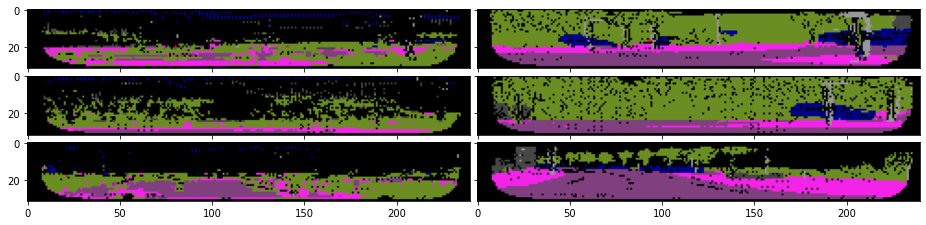

Domain Adaptation
                          Predictions                                                  Labels


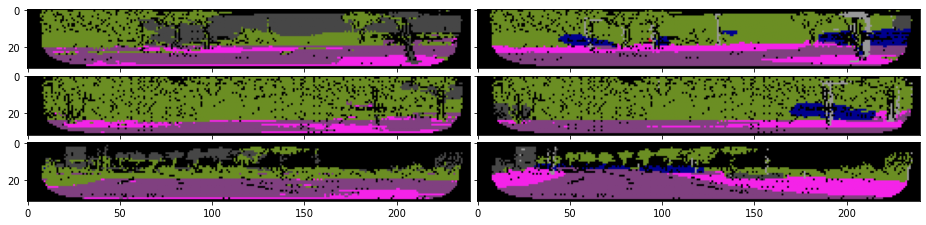

In [131]:
### Visualize Prediction and Label example

print('Benchmark (SemanticKITTI)')
visuPredictionLabel(val_paths, model_bench_kitti)
print('Domain Adaptation')
visuPredictionLabel(val_paths, model_da)

The comparison between the predictions and the labels confirms the low MIoU values of the SemanticKITTI comparison model. On the other hand, clear mispredictions can also be seen in the DA model, for example on the basis of the blue labels, which generally represent four-wheeled vehicles. The mispredicted classes were in most cases recognised by the model as buildings (dark grey) or vegetation (light green).

Finally, the Confusion Matrix is considered. At this point, since the low MIoU values when DA is applied to an unknown target dataset would not provide analysable results for the representation of a Confusion Matrix, the nuScenes validation dataset is used as the target domain. This way, the DA performance cannot be investigated but at least the behaviour of the comparison model trained on nuScenes in contrast to the optimised DA model can be compared

In [132]:
### Compute the presision and recall values according to each class

# Validate on bigger NuScenes dataset
val_paths = data_paths.VAL.NUSC
setConfig(val_paths)
val = create_dataset(val_paths, augmentation, batch_size=1)

print('Benchmark (NuScenes)')
conf_mat_bench = computeConfMat(val, model_bench_nusc)
print('Domain Adaptation')
conf_mat_da = computeConfMat(val, model_da)

Benchmark (NuScenes)
Class         Precision       Recall
Road         : 0.79415154     : 0.70567435
Sidewalk     : 0.18335736     : 0.041007567
Building     : 0.3838654      : 0.7194874
Pole         : 0.0015176303   : 0.0036349874
Vegetation   : 0.4719453      : 0.5589276
Person       : 0.112416565    : 0.07180778
TwoWheeler   : 0.077586204    : 3.859944e-05
Car          : 0.60933703     : 0.10599935
Truck        : 0.3254355      : 0.06793358
Bus          : 0.16681223     : 0.00041221807
None         : 0.99930525     : 0.7876432
Domain Adaptation
Class         Precision       Recall
Road         : 0.7740982      : 0.6504484
Sidewalk     : 0.27044618     : 0.043288294
Building     : 0.3658713      : 0.49209324
Pole         : 0.0017033987   : 0.005505588
Vegetation   : 0.44956818     : 0.7429406
Person       : 0.13388467     : 0.01859474
TwoWheeler   : 0.0            : 0.0
Car          : 0.5643282      : 0.09968203
Truck        : 0.18708816     : 0.010157008
Bus          : 0.016393442  

Benchmark (NuScenes)


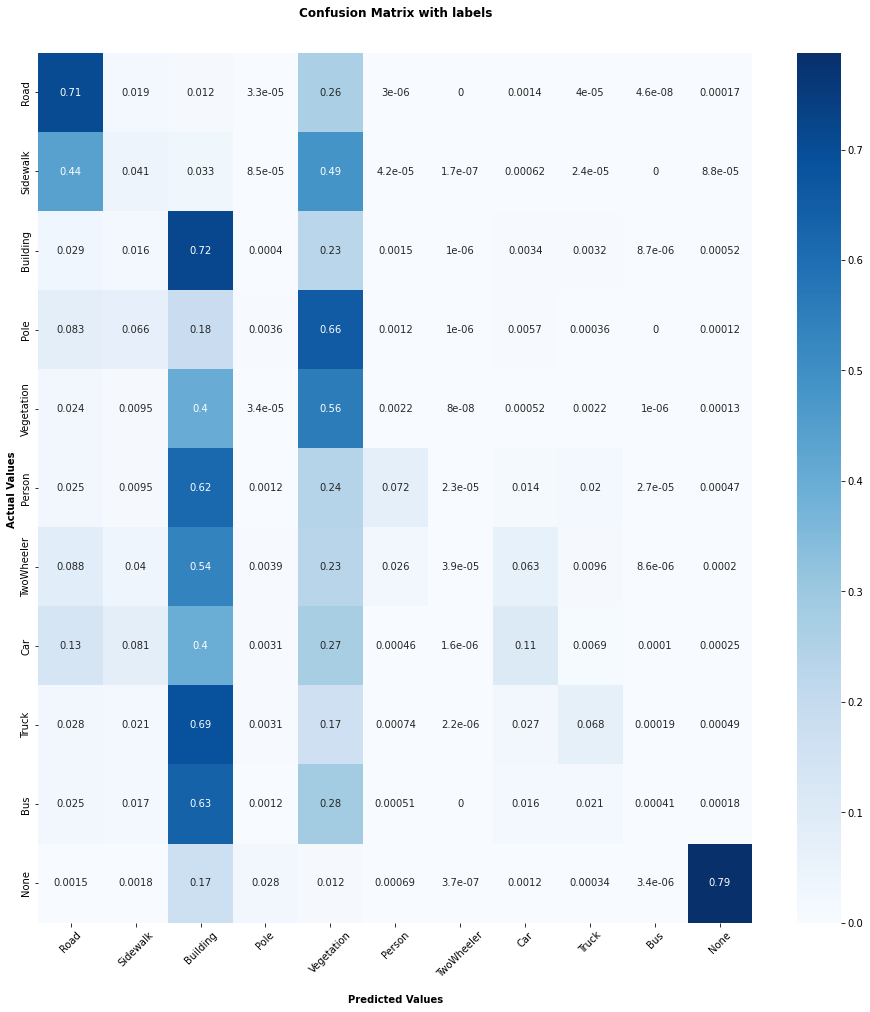

Domain Adaptation


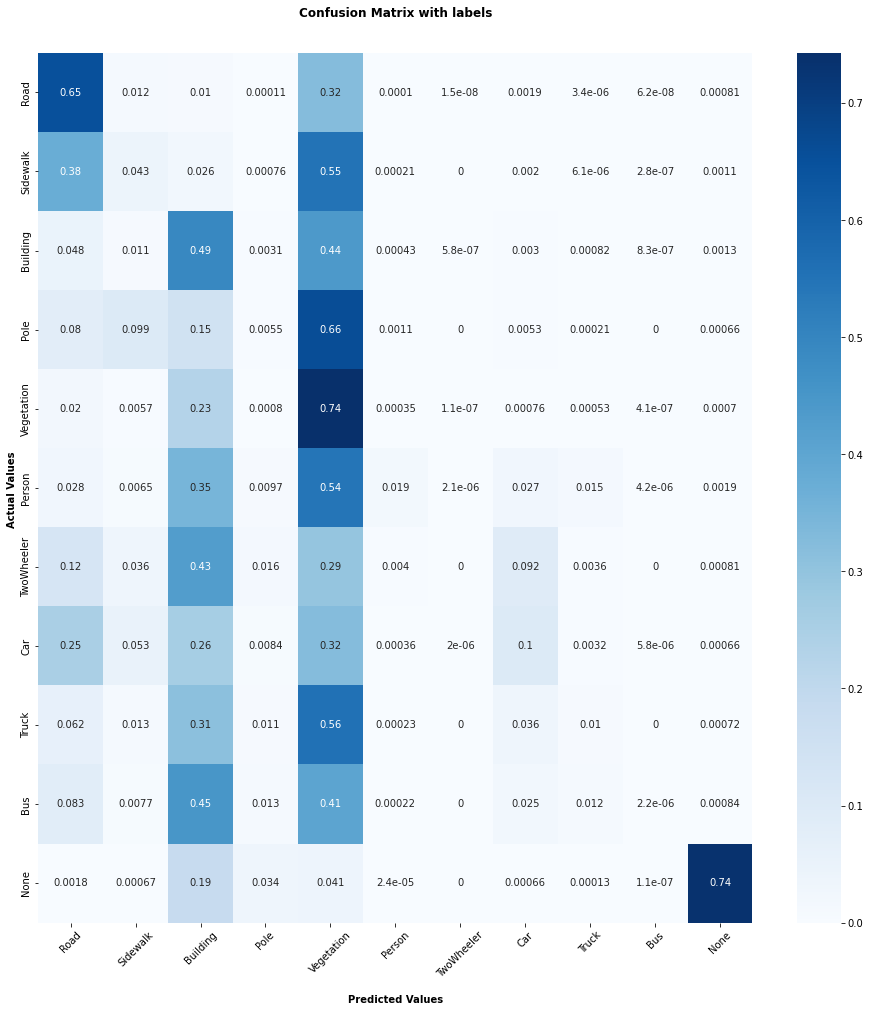

In [133]:
### Plot confusion matrix

print('Benchmark (NuScenes)')
plotConfMat(conf_mat_bench)

print('Domain Adaptation')
plotConfMat(conf_mat_da)

#### Discussion
  
The confusion matrices show a basically similar behaviour and performance, as the respective models are based on the same dataset. Interesting at this point is the column-wise misprediction for the classes buildings and vegetation. This confirms the previous finding that vehicles were mispredicted as vegetation by the model in the examples. This suggests that buildings and vegetation are overweighted in the training and this overweighting cannot be reduced even by augmentation. An overrepresentation of buildings and vegetation pixel or instances in the nuScenes dataset could be assumed, but this cannot be confirmed by the distribution of labelled points in the nuScenes dataset.  
In principle, the different labelling strategies nevertheless pose a problem, since with different numbers of classes either classes must be treated as unknown or, as in this case, must be combined, which can lead to an overrepresentation of individual classes.  
If we look at the performance of the models trained on the SemanticKITTI and NuScenes datasets on the ika validation dataset as an example, we can see that the model with the nuScenes training dataset achieves better results. This is theoretically contradicted by the fact that the SemanticKITTI and ika dataset were generated in Germany, while the NuScenes dataset only contains scenes outside Germany. From this, it can be exemplified that the domain shift in a pure dataset comparison cannot be broken down in detail to different sub-aspects (such as weather, sensor type, country), so it is challenging to make validated statements about detailed DA capabilities.  
In summary, a deep insight into the dataset properties is necessary to explain and evaluate the resulting model behaviour in a domain shift.  
  
To summarise the results obtained, the MIoU values of the methods investigated are shown together in the following plot. When the above code cells are executed, you may get slightly different results. This is due to certain randomization at different points. Overall, however, the results should differ only minimally from those shown and the basic behaviour should be recognisable.

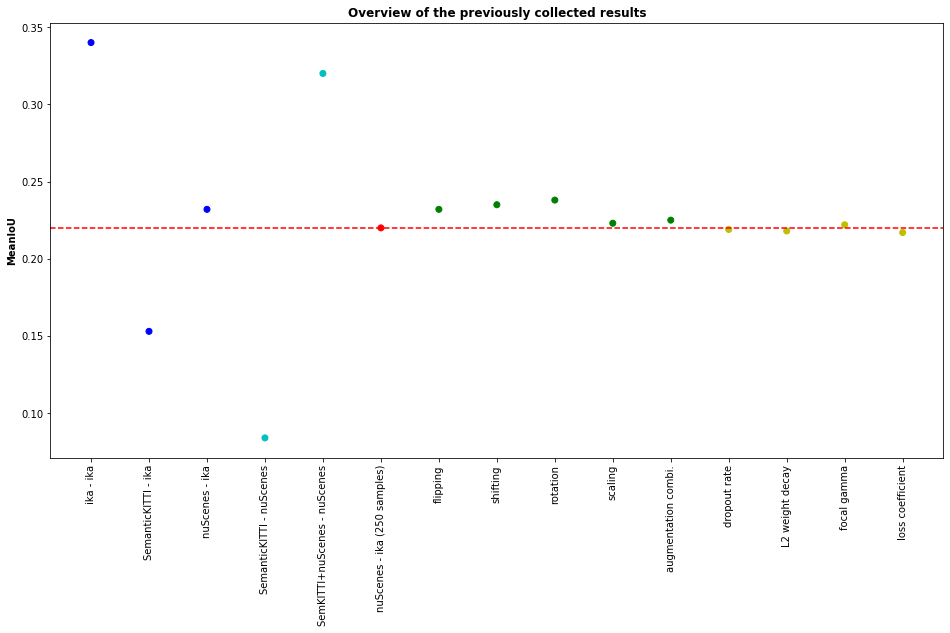

In [138]:
### Overview of the previously collected results as a plot
# The results were collected beforehand and are independent of the own code execution.

plt.figure(figsize = (16, 8))
plt.scatter(['ika - ika', 'SemanticKITTI - ika', 'nuScenes - ika', 
             'SemanticKITTI - nuScenes', 'SemKITTI+nuScenes - nuScenes', 'nuScenes - ika (250 samples)',
             'flipping', 'shifting', 'rotation', 'scaling', 'augmentation combi.',
             'dropout rate', 'L2 weight decay', 'focal gamma', 'loss coefficient'],
            [0.34, 0.153, 0.232, 
             0.084, 0.320, 0.220,
             0.232, 0.235, 0.238, 0.223, 0.225,
             0.219, 0.218, 0.222, 0.217],
             c=['b','b','b','c','c','r','g','g','g','g','g','y','y','y','y'])
plt.axhline(y=0.220, color='r', linestyle='dashed')
plt.xticks(rotation=90)
plt.ylabel("MeanIoU", fontweight='bold')
plt.title("Overview of the previously collected results", fontweight='bold')
plt.show;

The red horizontal dashed line marks the MIoU value of the comparison model, which serves as the starting model for the investigations regarding parameter tuning and augmentation. It can be seen that due to the optimisations, most of the MIoU values obtained from the experiments are above this comparison value, but the discrepancy is very small (green and yellow points). Some experiments even achieve worse values overall. This illustrates the small influence of these techniques on DA performance. The influence of the basic dataset selection for the training dataset can be seen from the first three characteristic values from the left (blue points). At the same time, the discrepancy with the ika-ika comparison value clearly shows the influence of a domain shift on the model performance. Interesting results are reflected in the MIoU values of the concatenation experiments (cyan points). Only by adding target data to 10% of the training dataset size, the MIoU score can be increased by more than three times.

### **Conclusion**

First, the topics of semantic point cloud segmentation and domain adaptation are introduced on the basis of related literature. On this basis, a methodology is designed against the background of the formulated research question. This defines the aspects of dataset selection, data augmentation and network parameters to be considered. In the experiments, these aspects are examined with a structured, iterative approach and compared with comparative models. Finally, the findings will be examined in detail in order to derive implementation recommendations. Based on these recommendations, a final model is classified using comparative models to derive the following key statements.  
It can be stated that fine-tuning network parameters and augmentation functions improve the training results of the used model as expected, but do not increase the domain adaptation performance. Only the investigated aspect of the training data set selection led to a clear discrepancy between the domain adaptation performance results of the considered models. The possibility of data set merging, in which a small portion of the target data is added to the initial data set, plays a special role here. Even small portions of target data in the training dataset lead to a significant improvement in DA behaviour.   

#### Outlook
  
In this work, a low-level investigation of individual parameters was carried out in order to derive direct implementation recommendations. Since these did not show significant improvements in DA performance, a mid-level investigation of the basic network design and structure is the logical next step. A high-level comparison between different existing and published network architectures is also useful.  
With respect to the selection of the training dataset, a detailed analysis of the dataset design and structure is the next research step. Integrating data from the target domain into the source domain is not trivial to implement in practice. It is useful to analyse different realisation possibilities in different development steps.


### References


| # | Year | Authors | Title |
| --- | --- | --- | --- |
| 01 | 2019 | J. Zhang, X. Zhao, Z. Chen, Z. Lu | [A Review of Deep Learning-Based Semantic Segmentation for Point Cloud](https://ieeexplore.ieee.org/document/8930503) |
| 02 | 2020 | T. Cortinhal, G. Tzelepis, E.E. Aksoy | [SalsaNext: Fast, Uncertainty-aware Semantic Segmentation of LiDAR Point Clouds for Autonomous Driving](https://arxiv.org/abs/2003.03653) |
| 03 | 2021 | W. Liu, Z. Luo, Y. Cai | [Adversarial unsupervised domain adaptation for 3D semantic segmentation with multi-modal learning](https://www.sciencedirect.com/science/article/abs/pii/S0924271621001131?via%3Dihub) |
| 04 | 2021 | L. Yi, B. Gong, T. Funkhouser | [Complete&Label:A Domain Adaptatio nApproach to Semantic Segmentation of LiDAR Point Clouds](http://arxiv.org/pdf/2007.08488v2) |
| 05 | 2021 | L. Triess, M. Dreissig, C. Rist, J. Zöllner | [A Survey on Deep Domain Adaptation for LiDAR Perception](https://ieeexplore.ieee.org/document/9669228) |
| 06 | 2020 | Y. Xie, J. Tian, X. Zhu | [Linking Points With Labels in 3D: A Review of Point Cloud Semantic Segmentation](https://ieeexplore.ieee.org/document/9028090) |
| 07 | 2019 | B. Wu, X. Zhou, S. Zhao, X. Yue, K. Keutzer | [SqueezeSegV2: Improved Model Structure and Unsupervised Domain Adaptation for Road-Object Segmentation from a LiDAR Point Cloud](https://ieeexplore.ieee.org/document/8793495) |
| 08 | 2005 | J.F. Lalonde, R. Unnikrishnan, N. Vandapel, M. Hebert | [Scale selection for classification of point-sampled 3D surfaces](https://ieeexplore.ieee.org/document/1443257?reason=concurrency) |
| 09 | 2009 | F. Moosmann, O. Pink, C. Stiller | [Segmentation of 3D lidar data in non-flat urban environments using a local convexity criterion](https://ieeexplore.ieee.org/document/5164280) |
| 10 | 2011 | B. Douillard, J. Underwood, N. Kuntz | [On the segmentation of 3D LIDAR point clouds](https://ieeexplore.ieee.org/document/5979818) |
| 11 | 2017 | D. Zermas, I. Izzat, N. Papanikolopoulos | [Fast segmentation of 3D point clouds: A paradigm on LiDAR data for autonomous vehicle applications](https://ieeexplore.ieee.org/document/7989591) |
| 12 | 2015 | D. Maturana, S. Scherer | [VoxNet: A 3D Convolutional Neural Network for real-time object recognition](https://ieeexplore.ieee.org/document/7353481) |
| 13 | 2019 | C. Choy, J. Gwak, S. Savarese | [4D Spatio-Temporal ConvNets: Minkowski Convolutional Neural Networks](https://ieeexplore.ieee.org/document/8953494) |
| 14 | 2018 | B. Graham, M. Engelcke, L. v.d. Maaten | [3D Semantic Segmentation with Submanifold Sparse Convolutional Networks](https://ieeexplore.ieee.org/document/8579059) |
| 15 | 2020 | Y. Zhang, Z. Zhou, P. David, X. Yue, Z. Xi, B. Gong, H. Foroosh | [PolarNet: An Improved Grid Representation for Online LiDAR Point Clouds Semantic Segmentation](https://ieeexplore.ieee.org/document/9156460) |
| 16 | 2020 | Y. Lyu, X. Huang, Z. Zhang | [Learning to Segment 3D Point Clouds in 2D Image Space](https://ieeexplore.ieee.org/document/9157034) |
| 17 | 2019 | A. Milioto, I. Vizzo, J. Behley, C. Stachniss | [RangeNet ++: Fast and Accurate LiDAR Semantic Segmentation](https://ieeexplore.ieee.org/document/8967762) |
| 18 | 2021 | Q. Hu, B. Yang, S. Khalid, W. Xiao, N. Trigoni, A. Markham | [Towards Semantic Segmentation of Urban-Scale 3D Point Clouds: A Dataset, Benchmarks and Challenges](https://ieeexplore.ieee.org/document/9578083) |
| 19 | 2021 | X. Xie, L. Bai, X. Huang | [Real-Time LiDAR Point Cloud Semantic Segmentation for Autonomous Driving](https://www.mdpi.com/2079-9292/11/1/11) |
| 20 | 2017| R. Qi, H. Su, M. Kaichun, L. Guibas | [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://ieeexplore.ieee.org/document/8099499) |
| 21 | 2017 | R. Qi, L. Yi, H. Su, L. Guibas | [PointNet++: Deep Hierarchical Feature Learning on Point Sets in a Metric Space](https://arxiv.org/abs/1706.02413) |
| 22 | 2018 | Y. Li, R. Bu, M. Sun, W. Wu | [PointCNN: Convolution On X-Transformed Points](https://arxiv.org/abs/1801.07791) |
| 23 | 2019 | F. Engelmann, T. Kontogianni, J. Schult, B. Leibe | [Know What Your Neighbors Do: 3D Semantic Segmentation of Point Clouds](https://link.springer.com/chapter/10.1007/978-3-030-11015-4_29) |
| 24 | 2018 | L. Landrieu, M. Simonovsky | [Large-Scale Point Cloud Semantic Segmentation with Superpoint Graphs](https://ieeexplore.ieee.org/document/8578577) |
| 25 | 2019 | Y. Guo, H. Wang, Q. Hu, H. Liu, L. Liu | [Deep Learning for 3D Point Clouds: A Survey](https://arxiv.org/abs/1912.12033) |
| 26 | 2020 | S.A. Bello, S. Yu, C. Wang | [Review: Deep Learning on 3D Point Clouds](https://www.mdpi.com/2072-4292/12/11/1729) |
| 27 | 2015 | Z. Wu, S. Song, A. Khosla | [3D ShapeNets: A deep representation for volumetric shapes](https://ieeexplore.ieee.org/document/7298801) |
| 28 | 2012 | N. Silberman, D. Hoiem, P. Kohil, R. Fergus | [Indoor Segmentation and Support Inference from RGBD Images](https://link.springer.com/chapter/10.1007/978-3-642-33715-4_54) |
| 29 | 2019 | J. Behley, M. Garbade, A. Milioto | [SemanticKITTI: A Dataset for Semantic Scene Understanding of LiDAR Sequences](https://ieeexplore.ieee.org/document/9010727) |
| 30 | 2019 | I. Zolanvari, S. Ruano, A. Rana | [DublinCity: Annotated LiDAR Point Cloud and its Applications](https://www.researchgate.net/publication/334612380_DublinCity_Annotated_LiDAR_Point_Cloud_and_its_Applications) |
| 31 | 2021 | P. Xiao, Z. Shao, S. Hao | [PandaSet: Advanced Sensor Suite Dataset for Autonomous Driving](http://arxiv.org/pdf/2112.12610v1) |
| 32 | 2017 | A. Dosovitskiy, G. Ros, F. Codevilla | [CARLA: An Open Urban Driving Simulator](https://www.researchgate.net/publication/321025516_CARLA_An_Open_Urban_Driving_Simulator) |
| 33 | 2018 | X. Yue, B. Wu, S.A. Seshia | [A LiDAR Point Cloud Generator: from a Virtual World to Autonomous Driving](https://par.nsf.gov/servlets/purl/10109208) |
| 34 | 2020 | H. Caesar, V. Bankiti, A.H. Lang, S. Vora | [nuScenes: A Multimodal Dataset for Autonomous Driving](https://ieeexplore.ieee.org/document/9156412) |
| 35 | 2018 | T-Y. Lin, P. Goyal, R. Girshick, K. He, P. Dollar | [Focal Loss for Dense Object Detection](https://ieeexplore.ieee.org/document/8417976) |


### Licence

MIT Licence

Copyright 2022 Institute for Automotive Engineering of RWTH Aachen University